In [88]:
import os
os.chdir('/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection/')

In [89]:
pwd

'/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection'

!pip uninstall moviepy

!pip install opencv-python==3.4.2.17

In [90]:
import numpy as np
import tensorflow as tf
import sys
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import moviepy.video.io.ImageSequenceClip
import re

In [91]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [92]:
PATH_TO_CKPT_PERSON = '/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_CKPT_MASK = '/home/ubuntu/Desktop/frozen_inference_graph_new_16k.pb'

In [93]:
def load_inference_graph():

    # load frozen tensorflow model into memory
    
    print("> ====== Loading frozen graph into memory")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_PERSON, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        sess = tf.Session(graph=detection_graph)
    print(">  ====== Inference graph loaded.")
    return detection_graph, sess

In [94]:
def load_inference_graph_mask():

    # load frozen tensorflow model into memory
    
    print("> ====== Loading frozen graph into memory")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT_MASK, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
        sess = tf.Session(graph=detection_graph)
    print(">  ====== Inference graph loaded.")
    return detection_graph, sess

In [95]:
def detect_objects(image_np, detection_graph, sess):
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name(
        'detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name(
        'detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name(
        'detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name(
        'num_detections:0')

    image_np_expanded = np.expand_dims(image_np, axis=0)

    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores,
            detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    return np.squeeze(boxes), np.squeeze(scores), np.squeeze(classes)

In [96]:
detection_graph, sess = load_inference_graph()

> ====== Loading frozen graph into memory
>  ====== Inference graph loaded.


In [97]:
detection_graph_mask, sess_mask = load_inference_graph_mask()

> ====== Loading frozen graph into memory
>  ====== Inference graph loaded.


In [98]:
category_index = label_map_util.create_category_index_from_labelmap("label_map.txt", use_display_name=True)

In [99]:
# video = "/home/ubuntu/Desktop/MTW-CCTVVideos/lift.mp4"
# video = "/home/ubuntu/Desktop/Vivek/Test Videos/Shopping_mall/Pantaloons.mp4"
# video='/home/ubuntu/Desktop/MTW-CCTVVideos/P3RECEPTION.mp4'
video='/home/ubuntu/Desktop/MTW-CCTVVideos/SCR_2.mp4'
# video = '/home/ubuntu/Desktop/Vivek/Test Videos/sample.mp4'

#capture video
cap = cv2.VideoCapture(video)
cnt=0
# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
ret,first_frame = cap.read()
#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
    if(cnt==2000):
      break

  # Break the loop
  else: 
    break

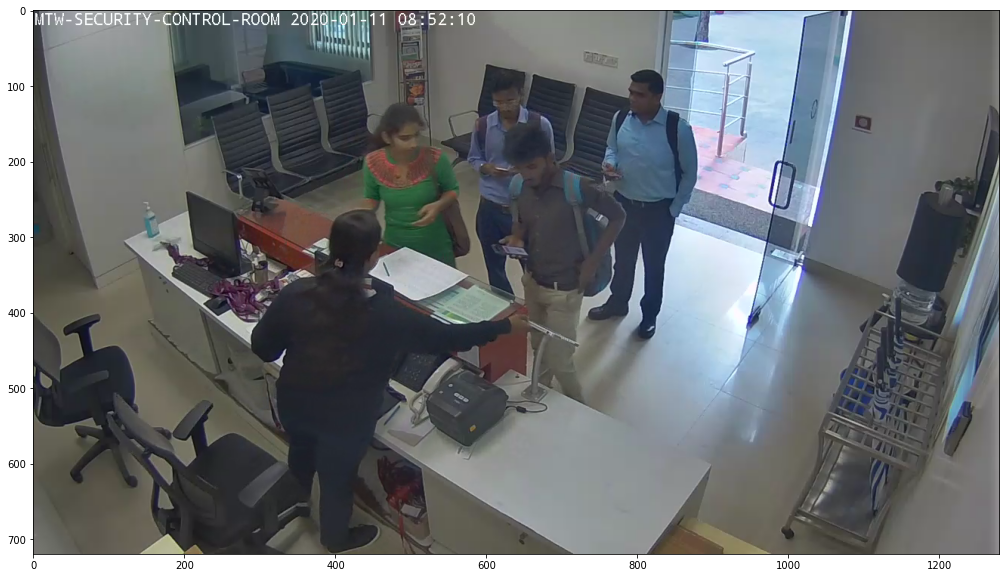

In [100]:
img = cv2.imread("frames/350.png")
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_height, im_width = img.shape[:2]
im_height,im_width
%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(img)

In [101]:
boxes, scores, classes = detect_objects(img, detection_graph, sess)

In [102]:
#identity only persons 
ind = np.where((classes==1) & (scores>0.85))
# print(classes)
print(ind)
#identify bounding box of only persons
person=boxes[ind]

#total no. of persons
num= len(person)
num

(array([0, 1, 2, 3]),)


4

In [103]:
def midpoint(img,person,idx):
    x1,y1,x2,y2 = person[idx]
    (left, right, top, bottom) = (y1 * im_width, y2 * im_width, 
                              x1 * im_height, x2 * im_height)
    p1 = (int(left), int(top))
    p2 = (int(right), int(bottom))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _ = cv2.rectangle(img, p1, p2, (0,0,255), 3)
    
    x_center = int((left+right)/2)
    y_center = int(bottom)
    
    center = (x_center, y_center)
    _ = cv2.circle(img, center, 5, (255, 0, 0), -1)
    cv2.putText(img, str(idx), center, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
    #plt.figure(figsize=(20,10))
    #plt.imshow(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return center

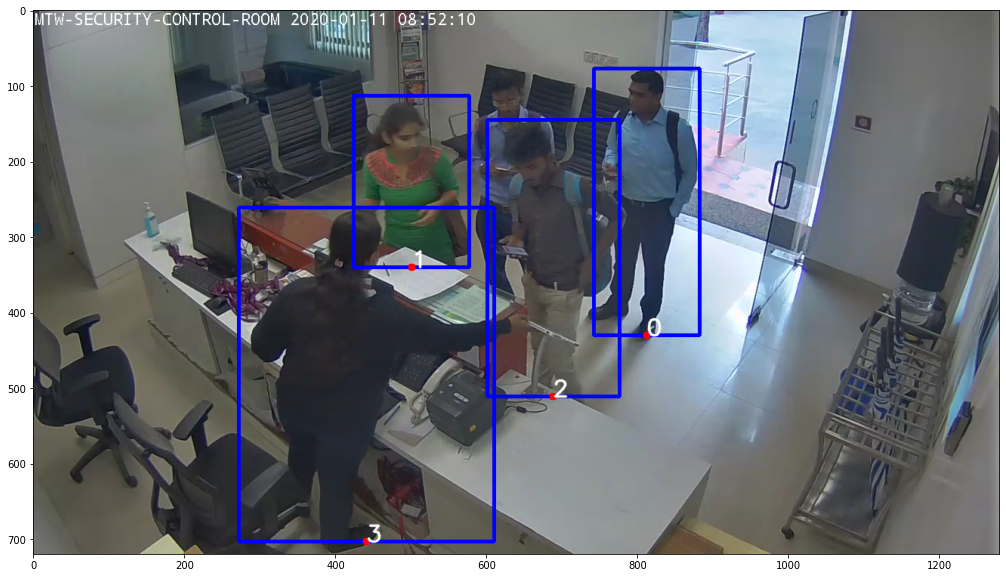

In [104]:
mid_pt =[midpoint(img,person,i) for i in range(len(person))]
plt.figure(figsize=(20,10))
plt.imshow(img)


In [105]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 15.3 µs


In [106]:
dist= compute_distance(mid_pt,num)

In [107]:
dist

array([[  0.        , 323.76071411, 148.11144453, 460.61914854],
       [  0.        ,   0.        , 253.39692184, 367.92526415],
       [  0.        ,   0.        ,   0.        , 312.84660778],
       [  0.        ,   0.        ,   0.        ,   0.        ]])

In [109]:
def find_closest(dist,num,thresh):
    p1=[]
    p2=[]
    d=[]
    for i in range(num):
        for j in range(i,num):
#             print("i and j",i,j)
#             print("dist i and j",dist[i][j])
            if( (i!=j) & (dist[i][j]<=thresh)):
#                 print("i&j",i,j)
                p1.append(i)
                p2.append(j)
                d.append(dist[i][j])
#     print("p11",p1)
#     print(p2)
#     print(d)
    return p1,p2,d    


In [110]:
import pandas as pd

thresh=200
p1,p2,d=find_closest(dist,num,thresh)
# print("p1",p1)
# print(p2)
# print(d)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

,p1,p2,dist
0,0,2,148.111445


In [111]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  print(risky)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    (left, right, top, bottom) = (y1 * im_width, y2 * im_width, 
                              x1 * im_height, x2 * im_height)
    pp1 = (int(left), int(top))
    pp2 = (int(right), int(bottom))
    #image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _ =cv2.rectangle(img, pp1, pp2, (255,0,0), 4)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2) 
    #plt.imshow(img)
  return img

[0 2]


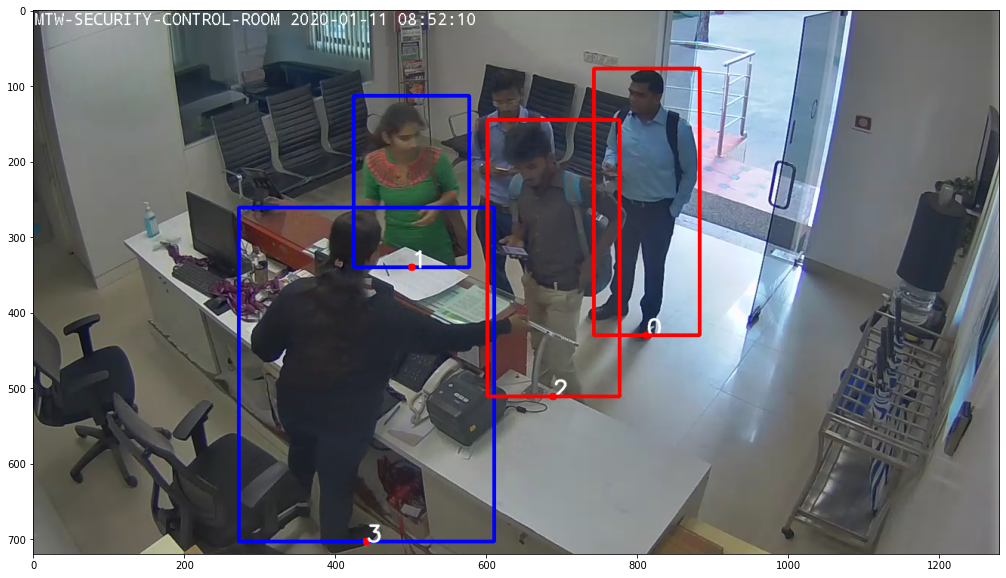

In [112]:
name='test.png'
img = change_2_red(img,person,p1,p2)
img_path='/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection/frames_update/test.png'

cv2.imwrite(img_path , cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(img)
# cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [43]:
import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [44]:
names

['0.png',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 '13.png',
 '14.png',
 '15.png',
 '16.png',
 '17.png',
 '18.png',
 '19.png',
 '20.png',
 '21.png',
 '22.png',
 '23.png',
 '24.png',
 '25.png',
 '26.png',
 '27.png',
 '28.png',
 '29.png',
 '30.png',
 '31.png',
 '32.png',
 '33.png',
 '34.png',
 '35.png',
 '36.png',
 '37.png',
 '38.png',
 '39.png',
 '40.png',
 '41.png',
 '42.png',
 '43.png',
 '44.png',
 '45.png',
 '46.png',
 '47.png',
 '48.png',
 '49.png',
 '50.png',
 '51.png',
 '52.png',
 '53.png',
 '54.png',
 '55.png',
 '56.png',
 '57.png',
 '58.png',
 '59.png',
 '60.png',
 '61.png',
 '62.png',
 '63.png',
 '64.png',
 '65.png',
 '66.png',
 '67.png',
 '68.png',
 '69.png',
 '70.png',
 '71.png',
 '72.png',
 '73.png',
 '74.png',
 '75.png',
 '76.png',
 '77.png',
 '78.png',
 '79.png',
 '80.png',
 '81.png',
 '82.png',
 '83.png',
 '84.png',
 '85.png',
 '86.png',
 '87.png',
 '88.png',
 '89.png',
 '90.png',
 '91.png'

In [45]:
def find_closest_people(name,thresh):
    img = cv2.imread('frames/'+ name )
    #plt.imshow(img)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img)
    im_height, im_width = img.shape[:2]
    boxes, scores, classes = detect_objects(img, detection_graph, sess)
    ind = np.where((classes==1) & (scores>0.80))
    print(ind)
    person=boxes[ind]
    #plt.imshow(img)
    mid_pt =[midpoint(img,person,i) for i in range(len(person))]
    #plt.imshow(img)
    num = len(mid_pt)
    dist= compute_distance(mid_pt,num)
    p1,p2,d=find_closest(dist,num,thresh)
    plt.imshow(img)
    img = change_2_red(img,person,p1,p2)
    #plt.imshow(img)
    cv2.imwrite('frames_update/'+name,cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return 0
    

  0%|          | 1/2000 [00:00<08:01,  4.15it/s]

(array([0, 1, 2]),)
[]


  0%|          | 2/2000 [00:00<07:51,  4.24it/s]

(array([0, 1, 2, 3]),)
[2 3]


  0%|          | 3/2000 [00:00<07:52,  4.23it/s]

(array([0, 1, 2]),)
[]


  0%|          | 4/2000 [00:00<07:47,  4.27it/s]

(array([0, 1, 2]),)
[]


  0%|          | 5/2000 [00:01<07:40,  4.33it/s]

(array([0, 1, 2]),)
[]


  0%|          | 6/2000 [00:01<07:38,  4.35it/s]

(array([0, 1, 2]),)
[]


  0%|          | 7/2000 [00:01<07:35,  4.38it/s]

(array([0, 1, 2]),)
[]


  0%|          | 8/2000 [00:01<07:34,  4.38it/s]

(array([0, 1, 2]),)
[]


  0%|          | 9/2000 [00:02<07:35,  4.38it/s]

(array([0, 1, 2]),)
[]


  0%|          | 10/2000 [00:02<07:35,  4.37it/s]

(array([0, 1, 2]),)
[]


  1%|          | 11/2000 [00:02<07:34,  4.38it/s]

(array([0, 1, 2]),)
[]


  1%|          | 12/2000 [00:02<07:33,  4.39it/s]

(array([0, 1, 2]),)
[]


  1%|          | 13/2000 [00:02<07:32,  4.39it/s]

(array([0, 1, 2]),)
[]


  1%|          | 14/2000 [00:03<07:36,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


  1%|          | 15/2000 [00:03<07:37,  4.34it/s]

(array([0, 1, 2]),)
[]


  1%|          | 16/2000 [00:03<07:31,  4.39it/s]

(array([0, 1, 2, 3]),)
[2 3]


  1%|          | 17/2000 [00:03<07:29,  4.41it/s]

(array([0, 1, 2]),)
[]


  1%|          | 18/2000 [00:04<07:27,  4.43it/s]

(array([0, 1, 2]),)
[]


  1%|          | 19/2000 [00:04<07:25,  4.45it/s]

(array([0, 1, 2]),)
[]


  1%|          | 20/2000 [00:04<07:25,  4.45it/s]

(array([0, 1]),)
[]


  1%|          | 21/2000 [00:04<07:24,  4.45it/s]

(array([0, 1]),)
[]


  1%|          | 22/2000 [00:05<07:22,  4.48it/s]

(array([0, 1, 2]),)
[]


  1%|          | 23/2000 [00:05<07:18,  4.51it/s]

(array([0, 1, 2]),)
[]


  1%|          | 24/2000 [00:05<07:18,  4.50it/s]

(array([0, 1, 2]),)
[]


  1%|▏         | 25/2000 [00:05<07:19,  4.50it/s]

(array([0, 1, 2]),)
[]


  1%|▏         | 26/2000 [00:05<07:19,  4.49it/s]

(array([0, 1, 2, 3]),)
[2 3]


  1%|▏         | 27/2000 [00:06<07:18,  4.50it/s]

(array([0, 1]),)
[]


  1%|▏         | 28/2000 [00:06<07:19,  4.49it/s]

(array([0, 1, 2]),)
[]


  1%|▏         | 29/2000 [00:06<07:23,  4.44it/s]

(array([0, 1]),)
[]


  2%|▏         | 30/2000 [00:06<07:23,  4.44it/s]

(array([0, 1, 2]),)
[]


  2%|▏         | 31/2000 [00:07<07:32,  4.35it/s]

(array([0, 1, 2]),)
[]


  2%|▏         | 32/2000 [00:07<07:31,  4.36it/s]

(array([0, 1, 2, 3]),)
[1 3]


  2%|▏         | 33/2000 [00:07<07:27,  4.39it/s]

(array([0, 1]),)
[]


  2%|▏         | 34/2000 [00:07<07:24,  4.42it/s]

(array([0, 1]),)
[]


  2%|▏         | 35/2000 [00:07<07:24,  4.42it/s]

(array([0, 1, 2]),)
[]


  2%|▏         | 36/2000 [00:08<07:29,  4.37it/s]

(array([0, 1]),)
[]


  2%|▏         | 37/2000 [00:08<07:37,  4.29it/s]

(array([0, 1, 2]),)
[]


  2%|▏         | 38/2000 [00:08<07:45,  4.22it/s]

(array([0, 1]),)
[]


  2%|▏         | 39/2000 [00:08<07:48,  4.18it/s]

(array([0, 1]),)
[]


  2%|▏         | 40/2000 [00:09<07:57,  4.10it/s]

(array([0]),)
[]


  2%|▏         | 41/2000 [00:09<07:54,  4.13it/s]

(array([0, 1]),)
[]


  2%|▏         | 42/2000 [00:09<07:57,  4.10it/s]

(array([0, 1, 2, 3]),)
[2 3]


  2%|▏         | 43/2000 [00:09<07:55,  4.12it/s]

(array([0, 1, 2, 3]),)
[2 3]


  2%|▏         | 44/2000 [00:10<08:05,  4.03it/s]

(array([0, 1, 2, 3]),)
[2 3]


  2%|▏         | 45/2000 [00:10<07:57,  4.09it/s]

(array([0, 1, 2]),)
[]


  2%|▏         | 46/2000 [00:10<08:01,  4.05it/s]

(array([0, 1, 2, 3]),)
[2 3]


  2%|▏         | 47/2000 [00:10<07:54,  4.12it/s]

(array([0, 1, 2, 3]),)
[2 3]


  2%|▏         | 48/2000 [00:11<07:46,  4.18it/s]

(array([0, 1]),)
[]


  2%|▏         | 49/2000 [00:11<07:49,  4.16it/s]

(array([0, 1, 2]),)
[1 2]


  2%|▎         | 50/2000 [00:11<07:42,  4.22it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 51/2000 [00:11<07:54,  4.11it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 52/2000 [00:12<07:54,  4.10it/s]

(array([0, 1]),)
[]


  3%|▎         | 53/2000 [00:12<07:50,  4.14it/s]

(array([0, 1]),)
[]


  3%|▎         | 54/2000 [00:12<07:44,  4.19it/s]

(array([0, 1]),)
[]


  3%|▎         | 55/2000 [00:12<07:43,  4.20it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 56/2000 [00:13<07:39,  4.23it/s]

(array([0, 1]),)
[]


  3%|▎         | 57/2000 [00:13<07:34,  4.27it/s]

(array([0, 1]),)
[]


  3%|▎         | 58/2000 [00:13<07:35,  4.27it/s]

(array([0, 1]),)
[]


  3%|▎         | 59/2000 [00:13<07:46,  4.16it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 60/2000 [00:13<07:37,  4.24it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 61/2000 [00:14<07:33,  4.27it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 62/2000 [00:14<07:32,  4.28it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 63/2000 [00:14<07:35,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


  3%|▎         | 64/2000 [00:14<07:39,  4.21it/s]

(array([0, 1]),)
[]


  3%|▎         | 65/2000 [00:15<07:33,  4.26it/s]

(array([0, 1]),)
[]


  3%|▎         | 66/2000 [00:15<07:33,  4.27it/s]

(array([0, 1]),)
[]


  3%|▎         | 67/2000 [00:15<07:38,  4.21it/s]

(array([0, 1]),)
[]


  3%|▎         | 68/2000 [00:15<07:38,  4.21it/s]

(array([0, 1]),)
[]


  3%|▎         | 69/2000 [00:16<07:35,  4.24it/s]

(array([0, 1]),)
[]


  4%|▎         | 70/2000 [00:16<07:36,  4.23it/s]

(array([0, 1]),)
[]


  4%|▎         | 71/2000 [00:16<07:31,  4.27it/s]

(array([0, 1]),)
[]


  4%|▎         | 72/2000 [00:16<07:20,  4.38it/s]

(array([0, 1]),)
[]


  4%|▎         | 73/2000 [00:16<07:14,  4.44it/s]

(array([0, 1]),)
[]


  4%|▎         | 74/2000 [00:17<07:06,  4.52it/s]

(array([0, 1]),)
[]


  4%|▍         | 75/2000 [00:17<07:04,  4.54it/s]

(array([0, 1]),)
[]


  4%|▍         | 76/2000 [00:17<07:02,  4.55it/s]

(array([0, 1, 2]),)
[1 2]


  4%|▍         | 77/2000 [00:17<06:59,  4.58it/s]

(array([0, 1]),)
[]


  4%|▍         | 78/2000 [00:18<07:01,  4.56it/s]

(array([0, 1]),)
[]


  4%|▍         | 79/2000 [00:18<06:57,  4.60it/s]

(array([0, 1, 2]),)
[1 2]


  4%|▍         | 80/2000 [00:18<06:55,  4.62it/s]

(array([0, 1]),)
[]


  4%|▍         | 81/2000 [00:18<06:59,  4.58it/s]

(array([0, 1]),)
[]


  4%|▍         | 82/2000 [00:18<06:59,  4.58it/s]

(array([0, 1, 2]),)
[1 2]


  4%|▍         | 83/2000 [00:19<06:58,  4.58it/s]

(array([0, 1]),)
[]


  4%|▍         | 84/2000 [00:19<06:58,  4.58it/s]

(array([0, 1, 2]),)
[1 2]


  4%|▍         | 85/2000 [00:19<06:58,  4.57it/s]

(array([0, 1]),)
[]


  4%|▍         | 86/2000 [00:19<07:00,  4.56it/s]

(array([0, 1]),)
[]


  4%|▍         | 87/2000 [00:20<06:59,  4.56it/s]

(array([0, 1]),)
[]


  4%|▍         | 88/2000 [00:20<06:59,  4.56it/s]

(array([0]),)
[]


  4%|▍         | 89/2000 [00:20<07:00,  4.54it/s]

(array([0, 1, 2]),)
[1 2]


  4%|▍         | 90/2000 [00:20<07:00,  4.54it/s]

(array([0]),)
[]


  5%|▍         | 91/2000 [00:20<07:00,  4.54it/s]

(array([0]),)
[]


  5%|▍         | 92/2000 [00:21<06:59,  4.54it/s]

(array([0, 1]),)
[]


  5%|▍         | 93/2000 [00:21<06:59,  4.54it/s]

(array([0, 1]),)
[]


  5%|▍         | 94/2000 [00:21<06:58,  4.55it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▍         | 95/2000 [00:21<07:04,  4.48it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▍         | 96/2000 [00:22<07:03,  4.50it/s]

(array([0, 1]),)
[]


  5%|▍         | 97/2000 [00:22<07:04,  4.48it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▍         | 98/2000 [00:22<07:10,  4.42it/s]

(array([0, 1]),)
[]


  5%|▍         | 99/2000 [00:22<07:12,  4.39it/s]

(array([0, 1]),)
[]


  5%|▌         | 100/2000 [00:22<07:12,  4.40it/s]

(array([0, 1]),)
[]


  5%|▌         | 101/2000 [00:23<07:12,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 102/2000 [00:23<07:15,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 103/2000 [00:23<07:18,  4.33it/s]

(array([0, 1]),)
[]


  5%|▌         | 104/2000 [00:23<07:17,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 105/2000 [00:24<07:15,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 106/2000 [00:24<07:15,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 107/2000 [00:24<07:13,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 108/2000 [00:24<07:10,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


  5%|▌         | 109/2000 [00:24<07:09,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


  6%|▌         | 110/2000 [00:25<07:07,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


  6%|▌         | 111/2000 [00:25<07:09,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


  6%|▌         | 112/2000 [00:25<07:08,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


  6%|▌         | 113/2000 [00:25<07:08,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


  6%|▌         | 114/2000 [00:26<07:09,  4.40it/s]

(array([0, 1]),)
[]


  6%|▌         | 115/2000 [00:26<07:06,  4.42it/s]

(array([0, 1]),)
[]


  6%|▌         | 116/2000 [00:26<07:07,  4.40it/s]

(array([0, 1]),)
[]


  6%|▌         | 117/2000 [00:26<07:05,  4.42it/s]

(array([0, 1]),)
[]


  6%|▌         | 118/2000 [00:27<07:08,  4.39it/s]

(array([0, 1]),)
[]


  6%|▌         | 119/2000 [00:27<07:11,  4.36it/s]

(array([0, 1]),)
[]


  6%|▌         | 120/2000 [00:27<07:09,  4.37it/s]

(array([0, 1]),)
[]


  6%|▌         | 121/2000 [00:27<07:05,  4.42it/s]

(array([0, 1]),)
[]


  6%|▌         | 122/2000 [00:27<07:03,  4.43it/s]

(array([0, 1]),)
[]


  6%|▌         | 123/2000 [00:28<06:59,  4.48it/s]

(array([0, 1]),)
[]


  6%|▌         | 124/2000 [00:28<07:00,  4.47it/s]

(array([0, 1]),)
[]


  6%|▋         | 125/2000 [00:28<07:00,  4.46it/s]

(array([0, 1]),)
[]


  6%|▋         | 126/2000 [00:28<06:59,  4.46it/s]

(array([0, 1]),)
[]


  6%|▋         | 127/2000 [00:29<06:59,  4.47it/s]

(array([0, 1]),)
[]


  6%|▋         | 128/2000 [00:29<07:00,  4.45it/s]

(array([0, 1]),)
[]


  6%|▋         | 129/2000 [00:29<07:01,  4.44it/s]

(array([0, 1]),)
[]


  6%|▋         | 130/2000 [00:29<07:00,  4.45it/s]

(array([0, 1]),)
[]


  7%|▋         | 131/2000 [00:29<07:02,  4.42it/s]

(array([0, 1]),)
[]


  7%|▋         | 132/2000 [00:30<07:06,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


  7%|▋         | 133/2000 [00:30<07:04,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 134/2000 [00:30<07:06,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


  7%|▋         | 135/2000 [00:30<07:04,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


  7%|▋         | 136/2000 [00:31<07:03,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 137/2000 [00:31<07:03,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 138/2000 [00:31<07:00,  4.43it/s]

(array([0]),)
[]


  7%|▋         | 139/2000 [00:31<07:00,  4.43it/s]

(array([0, 1]),)
[]


  7%|▋         | 140/2000 [00:31<06:55,  4.48it/s]

(array([0, 1]),)
[]


  7%|▋         | 141/2000 [00:32<06:53,  4.49it/s]

(array([0, 1]),)
[]


  7%|▋         | 142/2000 [00:32<06:59,  4.43it/s]

(array([0, 1]),)
[]


  7%|▋         | 143/2000 [00:32<07:03,  4.39it/s]

(array([0, 1]),)
[]


  7%|▋         | 144/2000 [00:32<07:02,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 145/2000 [00:33<07:01,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 146/2000 [00:33<06:58,  4.43it/s]

(array([0, 1]),)
[]


  7%|▋         | 147/2000 [00:33<07:01,  4.40it/s]

(array([0, 1]),)
[]


  7%|▋         | 148/2000 [00:33<07:01,  4.39it/s]

(array([0, 1]),)
[]


  7%|▋         | 149/2000 [00:34<07:00,  4.41it/s]

(array([0, 1]),)
[]


  8%|▊         | 150/2000 [00:34<06:58,  4.42it/s]

(array([0, 1]),)
[]


  8%|▊         | 151/2000 [00:34<06:58,  4.42it/s]

(array([0, 1]),)
[]


  8%|▊         | 152/2000 [00:34<06:54,  4.46it/s]

(array([0, 1]),)
[]


  8%|▊         | 153/2000 [00:34<06:51,  4.49it/s]

(array([0, 1]),)
[]


  8%|▊         | 154/2000 [00:35<06:52,  4.48it/s]

(array([0, 1]),)
[]


  8%|▊         | 155/2000 [00:35<06:57,  4.42it/s]

(array([0, 1]),)
[]


  8%|▊         | 156/2000 [00:35<06:57,  4.42it/s]

(array([0, 1]),)
[]


  8%|▊         | 157/2000 [00:35<06:57,  4.41it/s]

(array([0, 1]),)
[]


  8%|▊         | 158/2000 [00:36<06:58,  4.40it/s]

(array([0, 1]),)
[]


  8%|▊         | 159/2000 [00:36<06:57,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


  8%|▊         | 160/2000 [00:36<07:00,  4.37it/s]

(array([0, 1]),)
[]


  8%|▊         | 161/2000 [00:36<07:03,  4.34it/s]

(array([0, 1]),)
[]


  8%|▊         | 162/2000 [00:36<07:04,  4.33it/s]

(array([0, 1]),)
[]


  8%|▊         | 163/2000 [00:37<07:00,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


  8%|▊         | 164/2000 [00:37<07:02,  4.34it/s]

(array([0, 1]),)
[]


  8%|▊         | 165/2000 [00:37<07:02,  4.34it/s]

(array([0, 1]),)
[]


  8%|▊         | 166/2000 [00:37<07:00,  4.36it/s]

(array([0, 1]),)
[]


  8%|▊         | 167/2000 [00:38<06:59,  4.37it/s]

(array([0, 1]),)
[]


  8%|▊         | 168/2000 [00:38<06:56,  4.40it/s]

(array([0, 1]),)
[]


  8%|▊         | 169/2000 [00:38<06:51,  4.45it/s]

(array([0]),)
[]


  8%|▊         | 170/2000 [00:38<06:57,  4.39it/s]

(array([0]),)
[]


  9%|▊         | 171/2000 [00:39<06:56,  4.39it/s]

(array([0]),)
[]


  9%|▊         | 172/2000 [00:39<06:53,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▊         | 173/2000 [00:39<06:52,  4.43it/s]

(array([0, 1]),)
[]


  9%|▊         | 174/2000 [00:39<06:53,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 175/2000 [00:39<06:59,  4.35it/s]

(array([0, 1]),)
[]


  9%|▉         | 176/2000 [00:40<06:58,  4.36it/s]

(array([0, 1]),)
[]


  9%|▉         | 177/2000 [00:40<06:55,  4.38it/s]

(array([0, 1]),)
[]


  9%|▉         | 178/2000 [00:40<06:52,  4.42it/s]

(array([0, 1]),)
[]


  9%|▉         | 179/2000 [00:40<06:57,  4.37it/s]

(array([0, 1]),)
[]


  9%|▉         | 180/2000 [00:41<06:57,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 181/2000 [00:41<06:58,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 182/2000 [00:41<06:56,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 183/2000 [00:41<06:58,  4.35it/s]

(array([0, 1]),)
[]


  9%|▉         | 184/2000 [00:42<06:52,  4.40it/s]

(array([0, 1]),)
[]


  9%|▉         | 185/2000 [00:42<06:50,  4.42it/s]

(array([0, 1]),)
[]


  9%|▉         | 186/2000 [00:42<06:54,  4.38it/s]

(array([0, 1]),)
[]


  9%|▉         | 187/2000 [00:42<06:50,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 188/2000 [00:42<06:50,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


  9%|▉         | 189/2000 [00:43<06:55,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 190/2000 [00:43<06:59,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 191/2000 [00:43<06:56,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 192/2000 [00:43<06:51,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 193/2000 [00:44<06:47,  4.43it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 194/2000 [00:44<06:49,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 195/2000 [00:44<06:50,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 196/2000 [00:44<06:48,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 197/2000 [00:44<06:45,  4.44it/s]

(array([0, 1]),)
[]


 10%|▉         | 198/2000 [00:45<06:52,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 10%|▉         | 199/2000 [00:45<06:46,  4.43it/s]

(array([0, 1]),)
[]


 10%|█         | 200/2000 [00:45<06:51,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 201/2000 [00:45<06:50,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 202/2000 [00:46<06:53,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 203/2000 [00:46<06:49,  4.38it/s]

(array([0, 1]),)
[]


 10%|█         | 204/2000 [00:46<06:49,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 205/2000 [00:46<06:48,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 206/2000 [00:47<06:51,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 207/2000 [00:47<06:47,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 208/2000 [00:47<06:47,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 209/2000 [00:47<06:43,  4.44it/s]

(array([0, 1, 2]),)
[1 2]


 10%|█         | 210/2000 [00:47<06:42,  4.45it/s]

(array([0, 1, 2]),)
[1 2]


 11%|█         | 211/2000 [00:48<06:41,  4.45it/s]

(array([0, 1]),)
[]


 11%|█         | 212/2000 [00:48<06:44,  4.42it/s]

(array([0]),)
[]


 11%|█         | 213/2000 [00:48<06:42,  4.43it/s]

(array([0, 1]),)
[]


 11%|█         | 214/2000 [00:48<06:49,  4.36it/s]

(array([0, 1]),)
[]


 11%|█         | 215/2000 [00:49<06:54,  4.31it/s]

(array([0]),)
[]


 11%|█         | 216/2000 [00:49<06:58,  4.27it/s]

(array([0]),)
[]


 11%|█         | 217/2000 [00:49<06:55,  4.29it/s]

(array([0]),)
[]


 11%|█         | 218/2000 [00:49<06:54,  4.30it/s]

(array([0, 1]),)
[]


 11%|█         | 219/2000 [00:50<06:54,  4.30it/s]

(array([0, 1]),)
[]


 11%|█         | 220/2000 [00:50<06:49,  4.35it/s]

(array([0, 1]),)
[]


 11%|█         | 221/2000 [00:50<06:47,  4.37it/s]

(array([0, 1]),)
[]


 11%|█         | 222/2000 [00:50<06:50,  4.33it/s]

(array([0, 1]),)
[]


 11%|█         | 223/2000 [00:50<06:46,  4.37it/s]

(array([0]),)
[]


 11%|█         | 224/2000 [00:51<06:48,  4.35it/s]

(array([0, 1]),)
[]


 11%|█▏        | 225/2000 [00:51<06:47,  4.35it/s]

(array([0, 1]),)
[]


 11%|█▏        | 226/2000 [00:51<06:47,  4.35it/s]

(array([0, 1]),)
[]


 11%|█▏        | 227/2000 [00:51<06:46,  4.36it/s]

(array([0, 1]),)
[]


 11%|█▏        | 228/2000 [00:52<06:40,  4.42it/s]

(array([0]),)
[]


 11%|█▏        | 229/2000 [00:52<06:41,  4.41it/s]

(array([0, 1]),)
[]


 12%|█▏        | 230/2000 [00:52<06:41,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 231/2000 [00:52<06:38,  4.44it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 232/2000 [00:52<06:38,  4.44it/s]

(array([0, 1]),)
[]


 12%|█▏        | 233/2000 [00:53<06:44,  4.36it/s]

(array([0, 2]),)
[]


 12%|█▏        | 234/2000 [00:53<06:45,  4.35it/s]

(array([0, 2]),)
[]


 12%|█▏        | 235/2000 [00:53<06:45,  4.36it/s]

(array([0, 1, 3]),)
[1 2]


 12%|█▏        | 236/2000 [00:53<06:45,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 237/2000 [00:54<06:39,  4.41it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 238/2000 [00:54<06:40,  4.40it/s]

(array([0, 1]),)
[]


 12%|█▏        | 239/2000 [00:54<06:41,  4.39it/s]

(array([0, 1]),)
[]


 12%|█▏        | 240/2000 [00:54<06:40,  4.39it/s]

(array([0, 1]),)
[]


 12%|█▏        | 241/2000 [00:55<06:35,  4.45it/s]

(array([0, 1]),)
[]


 12%|█▏        | 242/2000 [00:55<06:34,  4.46it/s]

(array([0, 1]),)
[]


 12%|█▏        | 243/2000 [00:55<06:39,  4.40it/s]

(array([0, 1]),)
[]


 12%|█▏        | 244/2000 [00:55<06:48,  4.30it/s]

(array([0, 1]),)
[]


 12%|█▏        | 245/2000 [00:55<06:46,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 246/2000 [00:56<06:53,  4.24it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 247/2000 [00:56<06:46,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 248/2000 [00:56<06:41,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▏        | 249/2000 [00:56<06:39,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 12%|█▎        | 250/2000 [00:57<06:37,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 13%|█▎        | 251/2000 [00:57<06:36,  4.41it/s]

(array([0, 1]),)
[]


 13%|█▎        | 252/2000 [00:57<06:35,  4.42it/s]

(array([0, 1]),)
[]


 13%|█▎        | 253/2000 [00:57<06:30,  4.47it/s]

(array([0, 2]),)
[]


 13%|█▎        | 254/2000 [00:57<06:28,  4.49it/s]

(array([0, 1]),)
[]


 13%|█▎        | 255/2000 [00:58<06:33,  4.44it/s]

(array([0, 2]),)
[]


 13%|█▎        | 256/2000 [00:58<06:33,  4.43it/s]

(array([0, 2]),)
[]


 13%|█▎        | 257/2000 [00:58<06:39,  4.37it/s]

(array([0, 2, 3]),)
[1 2]


 13%|█▎        | 258/2000 [00:58<06:37,  4.38it/s]

(array([0, 1, 3]),)
[1 2]


 13%|█▎        | 259/2000 [00:59<06:36,  4.39it/s]

(array([0, 2, 3]),)
[1 2]


 13%|█▎        | 260/2000 [00:59<06:33,  4.42it/s]

(array([0, 1]),)
[]


 13%|█▎        | 261/2000 [00:59<06:34,  4.41it/s]

(array([0, 1, 3]),)
[1 2]


 13%|█▎        | 262/2000 [00:59<06:30,  4.45it/s]

(array([0, 1, 3]),)
[1 2]


 13%|█▎        | 263/2000 [01:00<06:31,  4.43it/s]

(array([0, 1, 2]),)
[1 2]


 13%|█▎        | 264/2000 [01:00<06:31,  4.44it/s]

(array([0, 1, 2]),)
[1 2]


 13%|█▎        | 265/2000 [01:00<06:35,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 13%|█▎        | 266/2000 [01:00<06:34,  4.40it/s]

(array([0, 1]),)
[]


 13%|█▎        | 267/2000 [01:00<06:36,  4.37it/s]

(array([0, 2, 3]),)
[1 2]


 13%|█▎        | 268/2000 [01:01<06:35,  4.38it/s]

(array([0, 2]),)
[]


 13%|█▎        | 269/2000 [01:01<06:36,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 14%|█▎        | 270/2000 [01:01<06:35,  4.38it/s]

(array([0, 1]),)
[]


 14%|█▎        | 271/2000 [01:01<06:34,  4.38it/s]

(array([0, 1]),)
[]


 14%|█▎        | 272/2000 [01:02<06:37,  4.35it/s]

(array([0, 1]),)
[]


 14%|█▎        | 273/2000 [01:02<06:38,  4.34it/s]

(array([0, 1]),)
[]


 14%|█▎        | 274/2000 [01:02<06:37,  4.34it/s]

(array([0, 1]),)
[]


 14%|█▍        | 275/2000 [01:02<06:35,  4.36it/s]

(array([0, 1]),)
[]


 14%|█▍        | 276/2000 [01:03<06:34,  4.37it/s]

(array([0, 1]),)
[]


 14%|█▍        | 277/2000 [01:03<06:32,  4.39it/s]

(array([0, 1]),)
[]


 14%|█▍        | 278/2000 [01:03<06:30,  4.41it/s]

(array([0, 2]),)
[]


 14%|█▍        | 279/2000 [01:03<06:29,  4.42it/s]

(array([0]),)
[]


 14%|█▍        | 280/2000 [01:03<06:32,  4.39it/s]

(array([0, 1]),)
[]


 14%|█▍        | 281/2000 [01:04<06:30,  4.40it/s]

(array([0, 2]),)
[]


 14%|█▍        | 282/2000 [01:04<06:34,  4.36it/s]

(array([0, 1]),)
[]


 14%|█▍        | 283/2000 [01:04<06:34,  4.35it/s]

(array([0, 1]),)
[]


 14%|█▍        | 284/2000 [01:04<06:30,  4.39it/s]

(array([0, 1]),)
[]


 14%|█▍        | 285/2000 [01:05<06:28,  4.42it/s]

(array([0, 1]),)
[]


 14%|█▍        | 286/2000 [01:05<06:26,  4.43it/s]

(array([0, 2]),)
[]


 14%|█▍        | 287/2000 [01:05<06:26,  4.43it/s]

(array([0, 1]),)
[]


 14%|█▍        | 288/2000 [01:05<06:27,  4.42it/s]

(array([0, 1]),)
[]


 14%|█▍        | 289/2000 [01:05<06:26,  4.43it/s]

(array([0, 1]),)
[]


 14%|█▍        | 290/2000 [01:06<06:28,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▍        | 291/2000 [01:06<06:31,  4.37it/s]

(array([0, 1]),)
[]


 15%|█▍        | 292/2000 [01:06<06:31,  4.36it/s]

(array([0]),)
[]


 15%|█▍        | 293/2000 [01:06<06:31,  4.36it/s]

(array([0]),)
[]


 15%|█▍        | 294/2000 [01:07<06:24,  4.44it/s]

(array([0, 1]),)
[]


 15%|█▍        | 295/2000 [01:07<06:26,  4.41it/s]

(array([0, 1]),)
[]


 15%|█▍        | 296/2000 [01:07<06:28,  4.39it/s]

(array([0, 1]),)
[]


 15%|█▍        | 297/2000 [01:07<06:27,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▍        | 298/2000 [01:08<06:27,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▍        | 299/2000 [01:08<06:26,  4.41it/s]

(array([0, 1]),)
[]


 15%|█▌        | 300/2000 [01:08<06:26,  4.39it/s]

(array([0, 2]),)
[]


 15%|█▌        | 301/2000 [01:08<06:28,  4.37it/s]

(array([0, 1]),)
[]


 15%|█▌        | 302/2000 [01:08<06:26,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▌        | 303/2000 [01:09<06:26,  4.39it/s]

(array([0, 1]),)
[]


 15%|█▌        | 304/2000 [01:09<06:25,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▌        | 305/2000 [01:09<06:24,  4.41it/s]

(array([0, 1]),)
[]


 15%|█▌        | 306/2000 [01:09<06:24,  4.41it/s]

(array([0, 1]),)
[]


 15%|█▌        | 307/2000 [01:10<06:24,  4.40it/s]

(array([0, 1]),)
[]


 15%|█▌        | 308/2000 [01:10<06:23,  4.41it/s]

(array([0, 1]),)
[]


 15%|█▌        | 309/2000 [01:10<06:22,  4.42it/s]

(array([0, 1]),)
[]


 16%|█▌        | 310/2000 [01:10<06:21,  4.43it/s]

(array([0, 1]),)
[]


 16%|█▌        | 311/2000 [01:10<06:20,  4.44it/s]

(array([0, 1]),)
[]


 16%|█▌        | 312/2000 [01:11<06:21,  4.43it/s]

(array([0, 1]),)
[]


 16%|█▌        | 313/2000 [01:11<06:22,  4.41it/s]

(array([0, 1]),)
[]


 16%|█▌        | 314/2000 [01:11<06:22,  4.41it/s]

(array([0, 1]),)
[]


 16%|█▌        | 315/2000 [01:11<06:24,  4.38it/s]

(array([0, 1]),)
[]


 16%|█▌        | 316/2000 [01:12<06:27,  4.35it/s]

(array([0, 1]),)
[]


 16%|█▌        | 317/2000 [01:12<06:24,  4.37it/s]

(array([0, 1]),)
[]


 16%|█▌        | 318/2000 [01:12<06:22,  4.40it/s]

(array([0, 1]),)
[]


 16%|█▌        | 319/2000 [01:12<06:23,  4.38it/s]

(array([0, 1]),)
[]


 16%|█▌        | 320/2000 [01:12<06:19,  4.43it/s]

(array([0, 1]),)
[]


 16%|█▌        | 321/2000 [01:13<06:19,  4.42it/s]

(array([0, 1]),)
[]


 16%|█▌        | 322/2000 [01:13<06:21,  4.40it/s]

(array([0, 1]),)
[]


 16%|█▌        | 323/2000 [01:13<06:23,  4.37it/s]

(array([0, 1]),)
[]


 16%|█▌        | 324/2000 [01:13<06:23,  4.37it/s]

(array([0, 1]),)
[]


 16%|█▋        | 325/2000 [01:14<06:27,  4.32it/s]

(array([0, 1]),)
[]


 16%|█▋        | 326/2000 [01:14<06:23,  4.37it/s]

(array([0, 1]),)
[]


 16%|█▋        | 327/2000 [01:14<06:25,  4.34it/s]

(array([0, 1]),)
[]


 16%|█▋        | 328/2000 [01:14<06:24,  4.35it/s]

(array([0, 1]),)
[]


 16%|█▋        | 329/2000 [01:15<06:20,  4.40it/s]

(array([0, 1]),)
[]


 16%|█▋        | 330/2000 [01:15<06:18,  4.42it/s]

(array([0, 1]),)
[]


 17%|█▋        | 331/2000 [01:15<06:16,  4.44it/s]

(array([0, 1]),)
[]


 17%|█▋        | 332/2000 [01:15<06:21,  4.38it/s]

(array([0, 1]),)
[]


 17%|█▋        | 333/2000 [01:15<06:20,  4.38it/s]

(array([0, 1]),)
[]


 17%|█▋        | 334/2000 [01:16<06:19,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 335/2000 [01:16<06:21,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 336/2000 [01:16<06:19,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 337/2000 [01:16<07:06,  3.90it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 338/2000 [01:17<06:55,  4.00it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 339/2000 [01:17<06:47,  4.07it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 340/2000 [01:17<06:41,  4.13it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 17%|█▋        | 341/2000 [01:17<06:31,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 342/2000 [01:18<06:28,  4.27it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 17%|█▋        | 343/2000 [01:18<06:23,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 344/2000 [01:18<06:22,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 345/2000 [01:18<06:21,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 3]


 17%|█▋        | 346/2000 [01:19<06:18,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 347/2000 [01:19<06:20,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 348/2000 [01:19<06:16,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 17%|█▋        | 349/2000 [01:19<06:15,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 18%|█▊        | 350/2000 [01:19<06:13,  4.42it/s]

(array([0, 1, 2, 3]),)
[1 2]


 18%|█▊        | 351/2000 [01:20<06:23,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 18%|█▊        | 352/2000 [01:20<06:24,  4.29it/s]

(array([0, 1, 2, 3]),)
[1 2]


 18%|█▊        | 353/2000 [01:20<06:23,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 18%|█▊        | 354/2000 [01:20<06:31,  4.21it/s]

(array([0, 1, 2]),)
[1 2]


 18%|█▊        | 355/2000 [01:21<06:22,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 18%|█▊        | 356/2000 [01:21<06:17,  4.35it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 357/2000 [01:21<06:11,  4.43it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 358/2000 [01:21<06:16,  4.36it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 359/2000 [01:22<06:14,  4.38it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 360/2000 [01:22<06:10,  4.43it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 361/2000 [01:22<06:16,  4.35it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 362/2000 [01:22<06:17,  4.33it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 363/2000 [01:22<06:17,  4.33it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 364/2000 [01:23<06:17,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2]


 18%|█▊        | 365/2000 [01:23<06:18,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 18%|█▊        | 366/2000 [01:23<06:16,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 18%|█▊        | 367/2000 [01:23<06:14,  4.36it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 368/2000 [01:24<06:18,  4.31it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 369/2000 [01:24<06:13,  4.37it/s]

(array([0, 1, 2]),)
[]


 18%|█▊        | 370/2000 [01:24<06:09,  4.41it/s]

(array([0, 1, 2]),)
[]


 19%|█▊        | 371/2000 [01:24<06:14,  4.35it/s]

(array([0, 1, 2]),)
[]


 19%|█▊        | 372/2000 [01:25<06:09,  4.41it/s]

(array([0, 1, 2]),)
[]


 19%|█▊        | 373/2000 [01:25<06:13,  4.36it/s]

(array([0, 1, 2]),)
[]


 19%|█▊        | 374/2000 [01:25<06:13,  4.36it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 375/2000 [01:25<06:09,  4.40it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 376/2000 [01:25<06:10,  4.39it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 377/2000 [01:26<06:10,  4.38it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 378/2000 [01:26<06:09,  4.39it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 379/2000 [01:26<06:10,  4.37it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 380/2000 [01:26<06:12,  4.35it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 381/2000 [01:27<06:14,  4.33it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 382/2000 [01:27<06:14,  4.31it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 383/2000 [01:27<06:14,  4.32it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 384/2000 [01:27<06:11,  4.36it/s]

(array([0, 1, 2, 3]),)
[2 3]


 19%|█▉        | 385/2000 [01:28<06:09,  4.37it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 386/2000 [01:28<06:06,  4.40it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 387/2000 [01:28<06:12,  4.33it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 388/2000 [01:28<06:09,  4.37it/s]

(array([0, 1, 2]),)
[]


 19%|█▉        | 389/2000 [01:28<06:08,  4.37it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 390/2000 [01:29<06:10,  4.35it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 391/2000 [01:29<06:08,  4.37it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 392/2000 [01:29<06:08,  4.36it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 393/2000 [01:29<06:04,  4.41it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 394/2000 [01:30<06:05,  4.40it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 395/2000 [01:30<06:03,  4.42it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 396/2000 [01:30<06:05,  4.39it/s]

(array([0, 1, 2, 3]),)
[]


 20%|█▉        | 397/2000 [01:30<06:03,  4.40it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 398/2000 [01:30<06:03,  4.41it/s]

(array([0, 1, 2]),)
[]


 20%|█▉        | 399/2000 [01:31<06:00,  4.44it/s]

(array([0, 1, 2]),)
[]


 20%|██        | 400/2000 [01:31<05:59,  4.45it/s]

(array([0, 1, 2]),)
[]


 20%|██        | 401/2000 [01:31<06:01,  4.42it/s]

(array([0, 1, 2]),)
[]


 20%|██        | 402/2000 [01:31<06:05,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 403/2000 [01:32<06:07,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 404/2000 [01:32<06:04,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 405/2000 [01:32<06:01,  4.41it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 406/2000 [01:32<06:04,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 407/2000 [01:33<06:06,  4.34it/s]

(array([0, 1, 2]),)
[]


 20%|██        | 408/2000 [01:33<06:06,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 409/2000 [01:33<06:07,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 20%|██        | 410/2000 [01:33<06:10,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 411/2000 [01:33<06:09,  4.30it/s]

(array([0, 1, 2]),)
[]


 21%|██        | 412/2000 [01:34<06:12,  4.26it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 413/2000 [01:34<06:11,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 414/2000 [01:34<06:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 415/2000 [01:34<06:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 416/2000 [01:35<06:07,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 417/2000 [01:35<06:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 418/2000 [01:35<06:10,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 419/2000 [01:35<06:10,  4.26it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 420/2000 [01:36<06:10,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 421/2000 [01:36<06:10,  4.26it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 422/2000 [01:36<06:09,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██        | 423/2000 [01:36<06:08,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 21%|██        | 424/2000 [01:36<06:08,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 21%|██▏       | 425/2000 [01:37<06:05,  4.30it/s]

(array([0, 1, 2]),)
[]


 21%|██▏       | 426/2000 [01:37<06:06,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██▏       | 427/2000 [01:37<06:11,  4.23it/s]

(array([0, 1, 2]),)
[]


 21%|██▏       | 428/2000 [01:37<06:08,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 21%|██▏       | 429/2000 [01:38<06:05,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 430/2000 [01:38<06:06,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 431/2000 [01:38<06:02,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 432/2000 [01:38<06:01,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 433/2000 [01:39<06:04,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 22%|██▏       | 434/2000 [01:39<06:05,  4.28it/s]

(array([0, 1, 2, 3, 4, 5]),)
[4 5]


 22%|██▏       | 435/2000 [01:39<06:07,  4.26it/s]

(array([0, 1, 2, 3, 4]),)
[]


 22%|██▏       | 436/2000 [01:39<06:06,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[]


 22%|██▏       | 437/2000 [01:40<06:03,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 438/2000 [01:40<06:00,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 439/2000 [01:40<05:59,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 440/2000 [01:40<05:58,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 441/2000 [01:40<05:58,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 442/2000 [01:41<05:58,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 443/2000 [01:41<05:56,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 444/2000 [01:41<05:54,  4.39it/s]

(array([0, 1, 2, 3]),)
[]


 22%|██▏       | 445/2000 [01:41<05:56,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 22%|██▏       | 446/2000 [01:42<05:55,  4.38it/s]

(array([0, 1, 2]),)
[]


 22%|██▏       | 447/2000 [01:42<05:55,  4.37it/s]

(array([0, 1, 2]),)
[]


 22%|██▏       | 448/2000 [01:42<05:58,  4.33it/s]

(array([0, 1, 2]),)
[]


 22%|██▏       | 449/2000 [01:42<05:54,  4.37it/s]

(array([0, 1, 2]),)
[]


 22%|██▎       | 450/2000 [01:42<05:53,  4.39it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 451/2000 [01:43<05:52,  4.40it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 452/2000 [01:43<05:51,  4.41it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 453/2000 [01:43<05:50,  4.41it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 454/2000 [01:43<05:52,  4.39it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 455/2000 [01:44<05:54,  4.36it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 456/2000 [01:44<05:50,  4.40it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 457/2000 [01:44<05:51,  4.39it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 458/2000 [01:44<05:51,  4.38it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 459/2000 [01:45<05:51,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 460/2000 [01:45<05:54,  4.35it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 461/2000 [01:45<05:51,  4.38it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 462/2000 [01:45<05:53,  4.35it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 463/2000 [01:45<05:54,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 464/2000 [01:46<05:51,  4.37it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 465/2000 [01:46<05:52,  4.36it/s]

(array([0, 1, 2]),)
[]


 23%|██▎       | 466/2000 [01:46<05:51,  4.36it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 467/2000 [01:46<05:49,  4.39it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 468/2000 [01:47<05:50,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 23%|██▎       | 469/2000 [01:47<05:52,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▎       | 470/2000 [01:47<05:51,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▎       | 471/2000 [01:47<05:56,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▎       | 472/2000 [01:48<05:55,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▎       | 473/2000 [01:48<05:52,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▎       | 474/2000 [01:48<05:54,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 475/2000 [01:48<05:56,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 476/2000 [01:48<05:53,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 477/2000 [01:49<05:53,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 478/2000 [01:49<05:53,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 479/2000 [01:49<05:55,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[]


 24%|██▍       | 480/2000 [01:49<05:47,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[]


 24%|██▍       | 481/2000 [01:50<05:49,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 24%|██▍       | 482/2000 [01:50<05:47,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 24%|██▍       | 483/2000 [01:50<05:54,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 24%|██▍       | 484/2000 [01:50<05:48,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 485/2000 [01:51<05:46,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 24%|██▍       | 486/2000 [01:51<05:54,  4.27it/s]

(array([0, 1, 2, 3]),)
[2 3]


 24%|██▍       | 487/2000 [01:51<05:52,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 24%|██▍       | 488/2000 [01:51<05:47,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 24%|██▍       | 489/2000 [01:51<05:48,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 24%|██▍       | 490/2000 [01:52<05:47,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 25%|██▍       | 491/2000 [01:52<05:46,  4.36it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 492/2000 [01:52<05:45,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 493/2000 [01:52<05:47,  4.33it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 494/2000 [01:53<05:46,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 495/2000 [01:53<05:48,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 496/2000 [01:53<05:48,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 497/2000 [01:53<05:49,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 498/2000 [01:54<05:47,  4.33it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▍       | 499/2000 [01:54<05:46,  4.33it/s]

(array([0, 1, 2]),)
[]


 25%|██▌       | 500/2000 [01:54<05:47,  4.32it/s]

(array([0, 1, 2]),)
[]


 25%|██▌       | 501/2000 [01:54<05:43,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 25%|██▌       | 502/2000 [01:54<05:43,  4.37it/s]

(array([0, 1, 2, 4]),)
[1 3]


 25%|██▌       | 503/2000 [01:55<05:41,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 3]


 25%|██▌       | 504/2000 [01:55<05:41,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 3]


 25%|██▌       | 505/2000 [01:55<05:43,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 3]


 25%|██▌       | 506/2000 [01:55<05:42,  4.37it/s]

(array([0, 1, 2]),)
[]


 25%|██▌       | 507/2000 [01:56<05:41,  4.37it/s]

(array([0, 1, 2]),)
[]


 25%|██▌       | 508/2000 [01:56<05:39,  4.40it/s]

(array([0, 1, 2]),)
[]


 25%|██▌       | 509/2000 [01:56<05:41,  4.36it/s]

(array([0, 1, 2]),)
[]


 26%|██▌       | 510/2000 [01:56<05:40,  4.38it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 511/2000 [01:57<05:38,  4.39it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 512/2000 [01:57<05:36,  4.42it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 513/2000 [01:57<05:39,  4.37it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 514/2000 [01:57<05:42,  4.34it/s]

(array([0, 1]),)
[]


 26%|██▌       | 515/2000 [01:57<05:41,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 2 3]


 26%|██▌       | 516/2000 [01:58<05:39,  4.37it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 517/2000 [01:58<05:37,  4.39it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 518/2000 [01:58<05:38,  4.38it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 519/2000 [01:58<05:38,  4.37it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 520/2000 [01:59<05:39,  4.35it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 521/2000 [01:59<05:36,  4.39it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 522/2000 [01:59<05:37,  4.38it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 523/2000 [01:59<05:37,  4.37it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▌       | 524/2000 [01:59<05:37,  4.38it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▋       | 525/2000 [02:00<05:37,  4.36it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▋       | 526/2000 [02:00<05:36,  4.38it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▋       | 527/2000 [02:00<05:34,  4.40it/s]

(array([0, 1, 2]),)
[0 2]


 26%|██▋       | 528/2000 [02:00<05:35,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2]


 26%|██▋       | 529/2000 [02:01<05:40,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 26%|██▋       | 530/2000 [02:01<05:41,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 27%|██▋       | 531/2000 [02:01<05:40,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 27%|██▋       | 532/2000 [02:01<05:40,  4.31it/s]

(array([0, 1, 2]),)
[0 2]


 27%|██▋       | 533/2000 [02:02<05:38,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 27%|██▋       | 534/2000 [02:02<05:37,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[0 4]


 27%|██▋       | 535/2000 [02:02<05:36,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 536/2000 [02:02<05:35,  4.36it/s]

(array([0, 1, 2, 3]),)
[0 3]


 27%|██▋       | 537/2000 [02:02<05:37,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 3]


 27%|██▋       | 538/2000 [02:03<05:36,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 3]


 27%|██▋       | 539/2000 [02:03<05:32,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 3]


 27%|██▋       | 540/2000 [02:03<05:30,  4.42it/s]

(array([0, 1, 2, 3, 4]),)
[1 3]


 27%|██▋       | 541/2000 [02:03<05:30,  4.42it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 542/2000 [02:04<05:30,  4.41it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 543/2000 [02:04<05:32,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[1 2]


 27%|██▋       | 544/2000 [02:04<05:29,  4.43it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 545/2000 [02:04<05:31,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 546/2000 [02:05<05:30,  4.40it/s]

(array([0, 1, 2, 3]),)
[1 3]


 27%|██▋       | 547/2000 [02:05<05:31,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2]


 27%|██▋       | 548/2000 [02:05<05:33,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 27%|██▋       | 549/2000 [02:05<05:35,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 550/2000 [02:05<05:35,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 551/2000 [02:06<05:35,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 552/2000 [02:06<05:33,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 553/2000 [02:06<05:32,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 554/2000 [02:06<05:30,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 555/2000 [02:07<05:28,  4.40it/s]

(array([0, 1, 2]),)
[]


 28%|██▊       | 556/2000 [02:07<05:27,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 28%|██▊       | 557/2000 [02:07<05:28,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 28%|██▊       | 558/2000 [02:07<05:27,  4.41it/s]

(array([0, 1, 2]),)
[]


 28%|██▊       | 559/2000 [02:08<05:27,  4.40it/s]

(array([0, 1, 2]),)
[]


 28%|██▊       | 560/2000 [02:08<05:26,  4.42it/s]

(array([0, 1, 2, 3]),)
[1 2]


 28%|██▊       | 561/2000 [02:08<05:26,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 28%|██▊       | 562/2000 [02:08<05:25,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


 28%|██▊       | 563/2000 [02:08<05:28,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 28%|██▊       | 564/2000 [02:09<05:32,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 28%|██▊       | 565/2000 [02:09<05:29,  4.36it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 28%|██▊       | 566/2000 [02:09<05:26,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 28%|██▊       | 567/2000 [02:09<05:23,  4.43it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 28%|██▊       | 568/2000 [02:10<05:25,  4.40it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 28%|██▊       | 569/2000 [02:10<05:23,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


 28%|██▊       | 570/2000 [02:10<05:25,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▊       | 571/2000 [02:10<05:27,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▊       | 572/2000 [02:10<05:26,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▊       | 573/2000 [02:11<05:27,  4.36it/s]

(array([0, 1, 2, 3]),)
[1 2]


 29%|██▊       | 574/2000 [02:11<05:29,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 575/2000 [02:11<05:30,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 576/2000 [02:11<05:28,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 577/2000 [02:12<05:29,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 578/2000 [02:12<05:26,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 579/2000 [02:12<05:27,  4.34it/s]

(array([0, 1]),)
[]


 29%|██▉       | 580/2000 [02:12<05:25,  4.36it/s]

(array([0, 1]),)
[]


 29%|██▉       | 581/2000 [02:13<05:22,  4.40it/s]

(array([0, 1, 2]),)
[]


 29%|██▉       | 582/2000 [02:13<05:24,  4.37it/s]

(array([0, 1, 2]),)
[]


 29%|██▉       | 583/2000 [02:13<05:24,  4.36it/s]

(array([0, 1, 2]),)
[]


 29%|██▉       | 584/2000 [02:13<05:28,  4.31it/s]

(array([0, 1, 2]),)
[]


 29%|██▉       | 585/2000 [02:13<05:27,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 29%|██▉       | 586/2000 [02:14<05:25,  4.34it/s]

(array([0, 1]),)
[]


 29%|██▉       | 587/2000 [02:14<05:27,  4.32it/s]

(array([0, 1, 2]),)
[]


 29%|██▉       | 588/2000 [02:14<05:25,  4.34it/s]

(array([0, 1]),)
[]


 29%|██▉       | 589/2000 [02:14<05:26,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[1 3]


 30%|██▉       | 590/2000 [02:15<05:26,  4.32it/s]

(array([0, 1, 2]),)
[]


 30%|██▉       | 591/2000 [02:15<05:24,  4.34it/s]

(array([0, 1, 2]),)
[]


 30%|██▉       | 592/2000 [02:15<05:22,  4.36it/s]

(array([0, 1]),)
[]


 30%|██▉       | 593/2000 [02:15<05:21,  4.37it/s]

(array([0, 1, 2]),)
[]


 30%|██▉       | 594/2000 [02:16<05:21,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 30%|██▉       | 595/2000 [02:16<05:22,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 30%|██▉       | 596/2000 [02:16<05:20,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 30%|██▉       | 597/2000 [02:16<05:20,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 30%|██▉       | 598/2000 [02:16<05:20,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 30%|██▉       | 599/2000 [02:17<05:21,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 30%|███       | 600/2000 [02:17<05:23,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3]


 30%|███       | 601/2000 [02:17<05:24,  4.31it/s]

(array([0, 1]),)
[]


 30%|███       | 602/2000 [02:17<05:21,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 30%|███       | 603/2000 [02:18<05:20,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 30%|███       | 604/2000 [02:18<05:21,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 30%|███       | 605/2000 [02:18<05:23,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 30%|███       | 606/2000 [02:18<05:24,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 30%|███       | 607/2000 [02:19<05:22,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 30%|███       | 608/2000 [02:19<05:19,  4.35it/s]

(array([0, 1, 2]),)
[]


 30%|███       | 609/2000 [02:19<05:18,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[]


 30%|███       | 610/2000 [02:19<05:16,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[]


 31%|███       | 611/2000 [02:19<05:18,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 31%|███       | 612/2000 [02:20<05:17,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 31%|███       | 613/2000 [02:20<05:15,  4.40it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 614/2000 [02:20<05:18,  4.36it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 615/2000 [02:20<05:18,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 31%|███       | 616/2000 [02:21<05:17,  4.36it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 617/2000 [02:21<05:17,  4.36it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 618/2000 [02:21<05:19,  4.32it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 619/2000 [02:21<05:18,  4.33it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 620/2000 [02:22<05:17,  4.35it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 621/2000 [02:22<05:15,  4.37it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 622/2000 [02:22<05:12,  4.41it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 623/2000 [02:22<05:12,  4.41it/s]

(array([0, 1, 2]),)
[]


 31%|███       | 624/2000 [02:22<05:18,  4.32it/s]

(array([0, 1, 2]),)
[]


 31%|███▏      | 625/2000 [02:23<05:18,  4.31it/s]

(array([0, 1, 2]),)
[]


 31%|███▏      | 626/2000 [02:23<05:16,  4.34it/s]

(array([0, 1, 2]),)
[]


 31%|███▏      | 627/2000 [02:23<05:15,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 31%|███▏      | 628/2000 [02:23<05:14,  4.36it/s]

(array([0, 1, 2]),)
[]


 31%|███▏      | 629/2000 [02:24<05:15,  4.35it/s]

(array([0, 1, 2]),)
[]


 32%|███▏      | 630/2000 [02:24<05:14,  4.35it/s]

(array([0, 1, 2]),)
[]


 32%|███▏      | 631/2000 [02:24<05:12,  4.38it/s]

(array([0, 1, 2]),)
[]


 32%|███▏      | 632/2000 [02:24<05:13,  4.37it/s]

(array([0, 1, 2]),)
[]


 32%|███▏      | 633/2000 [02:24<05:12,  4.37it/s]

(array([0, 1]),)
[]


 32%|███▏      | 634/2000 [02:25<05:12,  4.37it/s]

(array([0, 1, 2]),)
[]


 32%|███▏      | 635/2000 [02:25<05:12,  4.37it/s]

(array([0, 1]),)
[]


 32%|███▏      | 636/2000 [02:25<05:11,  4.38it/s]

(array([0, 1]),)
[]


 32%|███▏      | 637/2000 [02:25<05:09,  4.40it/s]

(array([0, 1]),)
[]


 32%|███▏      | 638/2000 [02:26<05:12,  4.36it/s]

(array([0, 1]),)
[]


 32%|███▏      | 639/2000 [02:26<05:12,  4.35it/s]

(array([0, 1]),)
[]


 32%|███▏      | 640/2000 [02:26<05:11,  4.37it/s]

(array([0, 1]),)
[]


 32%|███▏      | 641/2000 [02:26<05:11,  4.36it/s]

(array([0, 1]),)
[]


 32%|███▏      | 642/2000 [02:27<05:13,  4.34it/s]

(array([0, 1]),)
[]


 32%|███▏      | 643/2000 [02:27<05:13,  4.33it/s]

(array([0, 1]),)
[]


 32%|███▏      | 644/2000 [02:27<05:15,  4.29it/s]

(array([0, 1]),)
[]


 32%|███▏      | 645/2000 [02:27<05:16,  4.28it/s]

(array([0, 1]),)
[]


 32%|███▏      | 646/2000 [02:27<05:14,  4.31it/s]

(array([0, 1]),)
[]


 32%|███▏      | 647/2000 [02:28<05:13,  4.32it/s]

(array([0, 1]),)
[]


 32%|███▏      | 648/2000 [02:28<05:12,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 32%|███▏      | 649/2000 [02:28<05:11,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 32%|███▎      | 650/2000 [02:28<05:10,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 33%|███▎      | 651/2000 [02:29<05:10,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 33%|███▎      | 652/2000 [02:29<05:08,  4.38it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 653/2000 [02:29<05:09,  4.35it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 654/2000 [02:29<05:09,  4.35it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 655/2000 [02:30<05:08,  4.35it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 656/2000 [02:30<05:09,  4.34it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 657/2000 [02:30<05:08,  4.35it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 658/2000 [02:30<05:09,  4.34it/s]

(array([0, 1]),)
[]


 33%|███▎      | 659/2000 [02:30<05:08,  4.34it/s]

(array([0, 1]),)
[]


 33%|███▎      | 660/2000 [02:31<05:06,  4.37it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 661/2000 [02:31<05:06,  4.38it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 662/2000 [02:31<05:04,  4.40it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 663/2000 [02:31<05:06,  4.36it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 664/2000 [02:32<05:04,  4.38it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 665/2000 [02:32<05:03,  4.40it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 666/2000 [02:32<05:02,  4.41it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 667/2000 [02:32<05:03,  4.40it/s]

(array([0, 1, 2]),)
[]


 33%|███▎      | 668/2000 [02:33<05:02,  4.40it/s]

(array([0, 1]),)
[]


 33%|███▎      | 669/2000 [02:33<05:02,  4.40it/s]

(array([0, 1]),)
[]


 34%|███▎      | 670/2000 [02:33<05:01,  4.41it/s]

(array([0, 1]),)
[]


 34%|███▎      | 671/2000 [02:33<05:02,  4.39it/s]

(array([0, 1]),)
[]


 34%|███▎      | 672/2000 [02:33<05:04,  4.36it/s]

(array([0]),)
[]


 34%|███▎      | 673/2000 [02:34<05:06,  4.32it/s]

(array([0]),)
[]


 34%|███▎      | 674/2000 [02:34<05:07,  4.31it/s]

(array([0, 1]),)
[]


 34%|███▍      | 675/2000 [02:34<05:07,  4.30it/s]

(array([0, 1]),)
[]


 34%|███▍      | 676/2000 [02:34<05:05,  4.33it/s]

(array([0, 1]),)
[]


 34%|███▍      | 677/2000 [02:35<05:03,  4.36it/s]

(array([0, 1]),)
[]


 34%|███▍      | 678/2000 [02:35<05:01,  4.39it/s]

(array([0, 1]),)
[]


 34%|███▍      | 679/2000 [02:35<05:02,  4.37it/s]

(array([0, 1]),)
[]


 34%|███▍      | 680/2000 [02:35<05:00,  4.39it/s]

(array([0, 1]),)
[]


 34%|███▍      | 681/2000 [02:36<05:02,  4.37it/s]

(array([0, 1, 2]),)
[]


 34%|███▍      | 682/2000 [02:36<05:01,  4.37it/s]

(array([0, 1, 2]),)
[]


 34%|███▍      | 683/2000 [02:36<05:02,  4.36it/s]

(array([0, 1, 2]),)
[]


 34%|███▍      | 684/2000 [02:36<05:02,  4.36it/s]

(array([0, 1, 2]),)
[]


 34%|███▍      | 685/2000 [02:36<05:00,  4.37it/s]

(array([0, 1, 2]),)
[]


 34%|███▍      | 686/2000 [02:37<05:02,  4.35it/s]

(array([0, 1]),)
[]


 34%|███▍      | 687/2000 [02:37<05:04,  4.31it/s]

(array([0, 1]),)
[]


 34%|███▍      | 688/2000 [02:37<05:03,  4.32it/s]

(array([0, 1]),)
[]


 34%|███▍      | 689/2000 [02:37<05:01,  4.34it/s]

(array([0, 1]),)
[]


 34%|███▍      | 690/2000 [02:38<05:02,  4.34it/s]

(array([0, 1]),)
[]


 35%|███▍      | 691/2000 [02:38<05:01,  4.34it/s]

(array([0, 1]),)
[]


 35%|███▍      | 692/2000 [02:38<05:00,  4.36it/s]

(array([0, 1]),)
[]


 35%|███▍      | 693/2000 [02:38<05:00,  4.35it/s]

(array([0, 1]),)
[]


 35%|███▍      | 694/2000 [02:38<05:02,  4.32it/s]

(array([0, 1]),)
[]


 35%|███▍      | 695/2000 [02:39<05:05,  4.26it/s]

(array([0, 1]),)
[]


 35%|███▍      | 696/2000 [02:39<05:05,  4.28it/s]

(array([0, 1]),)
[]


 35%|███▍      | 697/2000 [02:39<05:04,  4.28it/s]

(array([0, 1]),)
[]


 35%|███▍      | 698/2000 [02:39<05:06,  4.24it/s]

(array([0, 1]),)
[]


 35%|███▍      | 699/2000 [02:40<05:03,  4.28it/s]

(array([0, 1]),)
[]


 35%|███▌      | 700/2000 [02:40<05:02,  4.30it/s]

(array([0, 1]),)
[]


 35%|███▌      | 701/2000 [02:40<05:02,  4.29it/s]

(array([0, 1]),)
[]


 35%|███▌      | 702/2000 [02:40<05:02,  4.29it/s]

(array([0, 1]),)
[]


 35%|███▌      | 703/2000 [02:41<05:01,  4.30it/s]

(array([0, 1]),)
[]


 35%|███▌      | 704/2000 [02:41<05:00,  4.32it/s]

(array([0, 1]),)
[]


 35%|███▌      | 705/2000 [02:41<05:02,  4.28it/s]

(array([0, 1]),)
[]


 35%|███▌      | 706/2000 [02:41<05:01,  4.30it/s]

(array([0, 1]),)
[]


 35%|███▌      | 707/2000 [02:42<05:01,  4.29it/s]

(array([0, 1]),)
[]


 35%|███▌      | 708/2000 [02:42<04:58,  4.33it/s]

(array([0, 1]),)
[]


 35%|███▌      | 709/2000 [02:42<04:57,  4.33it/s]

(array([0, 1]),)
[]


 36%|███▌      | 710/2000 [02:42<04:57,  4.34it/s]

(array([0, 1]),)
[]


 36%|███▌      | 711/2000 [02:42<04:59,  4.31it/s]

(array([0, 1]),)
[]


 36%|███▌      | 712/2000 [02:43<04:57,  4.34it/s]

(array([0, 1]),)
[]


 36%|███▌      | 713/2000 [02:43<04:56,  4.34it/s]

(array([0, 1]),)
[]


 36%|███▌      | 714/2000 [02:43<04:59,  4.29it/s]

(array([0, 1]),)
[]


 36%|███▌      | 715/2000 [02:43<04:59,  4.29it/s]

(array([0, 1]),)
[]


 36%|███▌      | 716/2000 [02:44<05:00,  4.28it/s]

(array([0, 1]),)
[]


 36%|███▌      | 717/2000 [02:44<04:57,  4.32it/s]

(array([0, 1]),)
[]


 36%|███▌      | 718/2000 [02:44<04:55,  4.34it/s]

(array([0, 1]),)
[]


 36%|███▌      | 719/2000 [02:44<04:54,  4.35it/s]

(array([0, 1]),)
[]


 36%|███▌      | 720/2000 [02:45<04:53,  4.37it/s]

(array([0, 1]),)
[]


 36%|███▌      | 721/2000 [02:45<04:52,  4.37it/s]

(array([0, 1, 2]),)
[]


 36%|███▌      | 722/2000 [02:45<04:52,  4.38it/s]

(array([0, 1, 2]),)
[]


 36%|███▌      | 723/2000 [02:45<04:52,  4.37it/s]

(array([0, 1, 2]),)
[]


 36%|███▌      | 724/2000 [02:45<04:52,  4.37it/s]

(array([0, 1, 2]),)
[]


 36%|███▋      | 725/2000 [02:46<04:51,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 36%|███▋      | 726/2000 [02:46<04:51,  4.37it/s]

(array([0, 1, 2]),)
[]


 36%|███▋      | 727/2000 [02:46<04:49,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 36%|███▋      | 728/2000 [02:46<04:48,  4.40it/s]

(array([0, 1, 2]),)
[]


 36%|███▋      | 729/2000 [02:47<04:47,  4.41it/s]

(array([0, 1, 2]),)
[]


 36%|███▋      | 730/2000 [02:47<04:48,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 37%|███▋      | 731/2000 [02:47<04:50,  4.37it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 732/2000 [02:47<04:49,  4.38it/s]

(array([0, 1]),)
[]


 37%|███▋      | 733/2000 [02:48<04:51,  4.35it/s]

(array([0, 1]),)
[]


 37%|███▋      | 734/2000 [02:48<04:50,  4.35it/s]

(array([0, 1, 3]),)
[]


 37%|███▋      | 735/2000 [02:48<04:54,  4.30it/s]

(array([0, 1, 3, 4]),)
[2 3]


 37%|███▋      | 736/2000 [02:48<04:53,  4.31it/s]

(array([0, 1, 3]),)
[]


 37%|███▋      | 737/2000 [02:48<04:53,  4.30it/s]

(array([0, 1, 3]),)
[]


 37%|███▋      | 738/2000 [02:49<04:53,  4.30it/s]

(array([0, 1, 3, 4]),)
[2 3]


 37%|███▋      | 739/2000 [02:49<04:52,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 37%|███▋      | 740/2000 [02:49<04:52,  4.31it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 741/2000 [02:49<04:51,  4.32it/s]

(array([0, 1]),)
[]


 37%|███▋      | 742/2000 [02:50<04:50,  4.33it/s]

(array([0, 1, 2, 3]),)
[2 3]


 37%|███▋      | 743/2000 [02:50<04:47,  4.37it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 744/2000 [02:50<04:49,  4.34it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 745/2000 [02:50<04:48,  4.35it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 746/2000 [02:51<04:50,  4.32it/s]

(array([0, 1, 2]),)
[]


 37%|███▋      | 747/2000 [02:51<04:50,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 37%|███▋      | 748/2000 [02:51<04:50,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 37%|███▋      | 749/2000 [02:51<04:51,  4.30it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 750/2000 [02:51<04:50,  4.31it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 751/2000 [02:52<04:49,  4.32it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 752/2000 [02:52<04:49,  4.32it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 753/2000 [02:52<04:49,  4.30it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 754/2000 [02:52<04:50,  4.29it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 755/2000 [02:53<04:49,  4.30it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 756/2000 [02:53<04:48,  4.32it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 757/2000 [02:53<04:47,  4.32it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 758/2000 [02:53<04:46,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 38%|███▊      | 759/2000 [02:54<04:47,  4.32it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 760/2000 [02:54<04:46,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 38%|███▊      | 761/2000 [02:54<04:47,  4.31it/s]

(array([0, 1, 2]),)
[]


 38%|███▊      | 762/2000 [02:54<04:47,  4.31it/s]

(array([0, 1, 2]),)
[0 2]


 38%|███▊      | 763/2000 [02:54<04:46,  4.32it/s]

(array([0, 1, 2]),)
[0 2]


 38%|███▊      | 764/2000 [02:55<04:45,  4.32it/s]

(array([0, 1]),)
[]


 38%|███▊      | 765/2000 [02:55<04:44,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 38%|███▊      | 766/2000 [02:55<04:44,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 38%|███▊      | 767/2000 [02:55<04:47,  4.29it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 38%|███▊      | 768/2000 [02:56<04:46,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 38%|███▊      | 769/2000 [02:56<04:46,  4.30it/s]

(array([0, 1]),)
[]


 38%|███▊      | 770/2000 [02:56<04:47,  4.28it/s]

(array([0, 1, 2]),)
[]


 39%|███▊      | 771/2000 [02:56<04:48,  4.25it/s]

(array([0, 1]),)
[]


 39%|███▊      | 772/2000 [02:57<04:50,  4.23it/s]

(array([0, 1]),)
[]


 39%|███▊      | 773/2000 [02:57<04:47,  4.26it/s]

(array([0, 1, 2]),)
[]


 39%|███▊      | 774/2000 [02:57<04:45,  4.29it/s]

(array([0, 1, 2]),)
[]


 39%|███▉      | 775/2000 [02:57<04:43,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 39%|███▉      | 776/2000 [02:57<04:43,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 39%|███▉      | 777/2000 [02:58<04:42,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 39%|███▉      | 778/2000 [02:58<04:41,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 39%|███▉      | 779/2000 [02:58<04:41,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 39%|███▉      | 780/2000 [02:58<04:36,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[0 2 3]


 39%|███▉      | 781/2000 [02:59<04:36,  4.41it/s]

(array([0, 1, 2]),)
[]


 39%|███▉      | 782/2000 [02:59<04:34,  4.44it/s]

(array([0, 1, 2]),)
[]


 39%|███▉      | 783/2000 [02:59<04:35,  4.42it/s]

(array([0, 1, 2]),)
[]


 39%|███▉      | 784/2000 [02:59<04:37,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2 3]


 39%|███▉      | 785/2000 [03:00<04:40,  4.33it/s]

(array([0, 1, 2]),)
[]


 39%|███▉      | 786/2000 [03:00<04:40,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2 3]


 39%|███▉      | 787/2000 [03:00<04:41,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 2]


 39%|███▉      | 788/2000 [03:00<04:43,  4.28it/s]

(array([0, 1, 2, 3]),)
[0 2]


 39%|███▉      | 789/2000 [03:00<04:44,  4.25it/s]

(array([0, 1, 2, 3]),)
[0 2]


 40%|███▉      | 790/2000 [03:01<04:42,  4.29it/s]

(array([0, 1, 2]),)
[0 2]


 40%|███▉      | 791/2000 [03:01<04:42,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3]


 40%|███▉      | 792/2000 [03:01<04:41,  4.29it/s]

(array([0, 1, 2]),)
[0 2]


 40%|███▉      | 793/2000 [03:01<04:42,  4.27it/s]

(array([0, 1, 2]),)
[0 2]


 40%|███▉      | 794/2000 [03:02<04:41,  4.29it/s]

(array([0, 1, 2]),)
[]


 40%|███▉      | 795/2000 [03:02<04:40,  4.30it/s]

(array([0, 1, 2, 3]),)
[0 2 3]


 40%|███▉      | 796/2000 [03:02<04:39,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 2 3]


 40%|███▉      | 797/2000 [03:02<04:38,  4.32it/s]

(array([0, 1, 2]),)
[0 2]


 40%|███▉      | 798/2000 [03:03<04:39,  4.30it/s]

(array([0, 1, 2]),)
[]


 40%|███▉      | 799/2000 [03:03<04:38,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 40%|████      | 800/2000 [03:03<04:39,  4.29it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 5]


 40%|████      | 801/2000 [03:03<04:38,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2]


 40%|████      | 802/2000 [03:03<04:38,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 3]


 40%|████      | 803/2000 [03:04<04:37,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 40%|████      | 804/2000 [03:04<04:37,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 40%|████      | 805/2000 [03:04<04:36,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 3]


 40%|████      | 806/2000 [03:04<04:37,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 3]


 40%|████      | 807/2000 [03:05<04:37,  4.29it/s]

(array([0, 1, 2, 3]),)
[1 2]


 40%|████      | 808/2000 [03:05<04:38,  4.28it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 40%|████      | 809/2000 [03:05<04:38,  4.28it/s]

(array([0, 1, 2, 3]),)
[1 2]


 40%|████      | 810/2000 [03:05<04:36,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 41%|████      | 811/2000 [03:06<04:34,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 2]


 41%|████      | 812/2000 [03:06<04:33,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 3]


 41%|████      | 813/2000 [03:06<04:33,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 2]


 41%|████      | 814/2000 [03:06<04:33,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 2]


 41%|████      | 815/2000 [03:07<04:31,  4.36it/s]

(array([0, 1, 2]),)
[0 2]


 41%|████      | 816/2000 [03:07<04:31,  4.36it/s]

(array([0, 1, 2, 3]),)
[0 2]


 41%|████      | 817/2000 [03:07<04:32,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 3]


 41%|████      | 818/2000 [03:07<04:30,  4.37it/s]

(array([0, 1, 2, 3]),)
[0 3]


 41%|████      | 819/2000 [03:07<04:29,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 3]


 41%|████      | 820/2000 [03:08<04:29,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 3]


 41%|████      | 821/2000 [03:08<04:30,  4.36it/s]

(array([0, 1, 2, 3]),)
[1 3]


 41%|████      | 822/2000 [03:08<04:30,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 3]


 41%|████      | 823/2000 [03:08<04:31,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 3]


 41%|████      | 824/2000 [03:09<04:31,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 41%|████▏     | 825/2000 [03:09<04:30,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 41%|████▏     | 826/2000 [03:09<04:30,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 41%|████▏     | 827/2000 [03:09<04:31,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 41%|████▏     | 828/2000 [03:09<04:31,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 41%|████▏     | 829/2000 [03:10<04:31,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 830/2000 [03:10<04:30,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 831/2000 [03:10<04:30,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 832/2000 [03:10<04:30,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 833/2000 [03:11<04:29,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 834/2000 [03:11<04:28,  4.35it/s]

(array([0, 1, 2, 4]),)
[1 3]


 42%|████▏     | 835/2000 [03:11<04:30,  4.30it/s]

(array([0, 1, 2, 4]),)
[1 3]


 42%|████▏     | 836/2000 [03:11<04:31,  4.29it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 837/2000 [03:12<04:31,  4.28it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 838/2000 [03:12<04:30,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 839/2000 [03:12<04:29,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 840/2000 [03:12<04:25,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 841/2000 [03:13<04:31,  4.27it/s]

(array([0, 1, 2, 3]),)
[1 3]


 42%|████▏     | 842/2000 [03:13<04:29,  4.29it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 843/2000 [03:13<04:29,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 844/2000 [03:13<04:27,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 845/2000 [03:13<04:25,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 846/2000 [03:14<04:23,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 847/2000 [03:14<04:23,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 42%|████▏     | 848/2000 [03:14<04:22,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▏     | 849/2000 [03:14<04:23,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2]


 42%|████▎     | 850/2000 [03:15<04:24,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 851/2000 [03:15<04:25,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[1 2]


 43%|████▎     | 852/2000 [03:15<04:23,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 853/2000 [03:15<04:21,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 854/2000 [03:15<04:21,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 855/2000 [03:16<04:21,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 856/2000 [03:16<04:21,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2]


 43%|████▎     | 857/2000 [03:16<04:20,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 3]


 43%|████▎     | 858/2000 [03:16<04:22,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 3]


 43%|████▎     | 859/2000 [03:17<04:22,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 43%|████▎     | 860/2000 [03:17<04:21,  4.36it/s]

(array([0, 1, 2, 3]),)
[]


 43%|████▎     | 861/2000 [03:17<04:20,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2]


 43%|████▎     | 862/2000 [03:17<04:21,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 2]


 43%|████▎     | 863/2000 [03:18<04:20,  4.37it/s]

(array([0, 1, 2, 3]),)
[0 2]


 43%|████▎     | 864/2000 [03:18<04:23,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 2]


 43%|████▎     | 865/2000 [03:18<04:23,  4.30it/s]

(array([0, 1, 2, 3]),)
[0 2]


 43%|████▎     | 866/2000 [03:18<04:21,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 43%|████▎     | 867/2000 [03:18<04:20,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 43%|████▎     | 868/2000 [03:19<04:21,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 43%|████▎     | 869/2000 [03:19<04:21,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 44%|████▎     | 870/2000 [03:19<04:20,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 44%|████▎     | 871/2000 [03:19<04:19,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 44%|████▎     | 872/2000 [03:20<04:17,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 44%|████▎     | 873/2000 [03:20<04:19,  4.34it/s]

(array([0, 1, 2]),)
[]


 44%|████▎     | 874/2000 [03:20<04:24,  4.26it/s]

(array([0, 1, 2]),)
[]


 44%|████▍     | 875/2000 [03:20<04:29,  4.18it/s]

(array([0, 1, 2]),)
[]


 44%|████▍     | 876/2000 [03:21<04:34,  4.10it/s]

(array([0, 1, 2, 3]),)
[]


 44%|████▍     | 877/2000 [03:21<04:32,  4.12it/s]

(array([0, 1, 2]),)
[]


 44%|████▍     | 878/2000 [03:21<04:28,  4.18it/s]

(array([0, 1, 2]),)
[]


 44%|████▍     | 879/2000 [03:21<04:24,  4.23it/s]

(array([0, 1, 2]),)
[0 2]


 44%|████▍     | 880/2000 [03:22<04:20,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 44%|████▍     | 881/2000 [03:22<04:19,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 882/2000 [03:22<04:17,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 883/2000 [03:22<04:16,  4.35it/s]

(array([0, 1, 2]),)
[0 2]


 44%|████▍     | 884/2000 [03:22<04:16,  4.35it/s]

(array([0, 1, 2]),)
[0 2]


 44%|████▍     | 885/2000 [03:23<04:16,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 886/2000 [03:23<04:15,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 887/2000 [03:23<04:17,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 888/2000 [03:23<04:19,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 889/2000 [03:24<04:20,  4.26it/s]

(array([0, 1, 2]),)
[1 2]


 44%|████▍     | 890/2000 [03:24<04:20,  4.25it/s]

(array([0, 1, 2]),)
[0 2]


 45%|████▍     | 891/2000 [03:24<04:19,  4.27it/s]

(array([0, 1, 2]),)
[1 2]


 45%|████▍     | 892/2000 [03:24<04:20,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 45%|████▍     | 893/2000 [03:25<04:18,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 45%|████▍     | 894/2000 [03:25<04:15,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 45%|████▍     | 895/2000 [03:25<04:15,  4.32it/s]

(array([0, 1, 2]),)
[]


 45%|████▍     | 896/2000 [03:25<04:16,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 45%|████▍     | 897/2000 [03:25<04:15,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 45%|████▍     | 898/2000 [03:26<04:14,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 45%|████▍     | 899/2000 [03:26<04:12,  4.36it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 900/2000 [03:26<04:11,  4.37it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 901/2000 [03:26<04:10,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 902/2000 [03:27<04:10,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 45%|████▌     | 903/2000 [03:27<04:11,  4.36it/s]

(array([0, 1, 2, 3]),)
[]


 45%|████▌     | 904/2000 [03:27<04:09,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 905/2000 [03:27<04:08,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 906/2000 [03:28<04:10,  4.37it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 907/2000 [03:28<04:09,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 908/2000 [03:28<04:11,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 2]


 45%|████▌     | 909/2000 [03:28<04:12,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 910/2000 [03:28<04:13,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 911/2000 [03:29<04:12,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 912/2000 [03:29<04:11,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 913/2000 [03:29<04:11,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 914/2000 [03:29<04:14,  4.27it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 915/2000 [03:30<04:13,  4.27it/s]

(array([0, 1, 2, 3]),)
[1 2]


 46%|████▌     | 916/2000 [03:30<04:12,  4.29it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 917/2000 [03:30<04:10,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 918/2000 [03:30<04:08,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 919/2000 [03:31<04:07,  4.36it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 920/2000 [03:31<04:06,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 921/2000 [03:31<04:06,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 922/2000 [03:31<04:09,  4.33it/s]

(array([0, 1, 2]),)
[0 2]


 46%|████▌     | 923/2000 [03:31<04:09,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▌     | 924/2000 [03:32<04:09,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 925/2000 [03:32<04:07,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 926/2000 [03:32<04:08,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 927/2000 [03:32<04:08,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 928/2000 [03:33<04:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 929/2000 [03:33<04:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[0 2]


 46%|████▋     | 930/2000 [03:33<04:08,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 931/2000 [03:33<04:08,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 932/2000 [03:34<04:08,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 933/2000 [03:34<04:08,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 934/2000 [03:34<04:07,  4.31it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 935/2000 [03:34<04:07,  4.31it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 936/2000 [03:34<04:06,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 2]


 47%|████▋     | 937/2000 [03:35<04:04,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 2]


 47%|████▋     | 938/2000 [03:35<04:04,  4.35it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 939/2000 [03:35<04:03,  4.35it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 940/2000 [03:35<04:04,  4.34it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 941/2000 [03:36<04:06,  4.30it/s]

(array([0, 1, 2]),)
[0 2]


 47%|████▋     | 942/2000 [03:36<04:07,  4.28it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 47%|████▋     | 943/2000 [03:36<04:08,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 47%|████▋     | 944/2000 [03:36<04:10,  4.21it/s]

(array([0, 1, 2]),)
[1 2]


 47%|████▋     | 945/2000 [03:37<04:09,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 47%|████▋     | 946/2000 [03:37<04:09,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 47%|████▋     | 947/2000 [03:37<04:08,  4.24it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 47%|████▋     | 948/2000 [03:37<04:08,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 47%|████▋     | 949/2000 [03:38<04:09,  4.21it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 950/2000 [03:38<04:08,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 951/2000 [03:38<04:08,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 952/2000 [03:38<04:09,  4.21it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 953/2000 [03:38<04:06,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 954/2000 [03:39<04:05,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 955/2000 [03:39<04:05,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 956/2000 [03:39<04:05,  4.26it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 957/2000 [03:39<04:04,  4.26it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 958/2000 [03:40<04:04,  4.27it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 959/2000 [03:40<04:05,  4.24it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 48%|████▊     | 960/2000 [03:40<04:04,  4.26it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 961/2000 [03:40<04:01,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 962/2000 [03:41<04:00,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 963/2000 [03:41<03:59,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 964/2000 [03:41<03:57,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 965/2000 [03:41<03:57,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 966/2000 [03:41<03:57,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 967/2000 [03:42<03:56,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 48%|████▊     | 968/2000 [03:42<03:56,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 48%|████▊     | 969/2000 [03:42<03:54,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2]


 48%|████▊     | 970/2000 [03:42<03:53,  4.41it/s]

(array([0, 1, 2, 3]),)
[1 2]


 49%|████▊     | 971/2000 [03:43<03:52,  4.42it/s]

(array([0, 1, 2]),)
[1 2]


 49%|████▊     | 972/2000 [03:43<03:54,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 49%|████▊     | 973/2000 [03:43<03:53,  4.39it/s]

(array([0, 1, 2]),)
[1 2]


 49%|████▊     | 974/2000 [03:43<03:54,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 49%|████▉     | 975/2000 [03:44<03:54,  4.37it/s]

(array([0, 1]),)
[]


 49%|████▉     | 976/2000 [03:44<03:56,  4.33it/s]

(array([0, 1]),)
[]


 49%|████▉     | 977/2000 [03:44<03:55,  4.34it/s]

(array([0, 1]),)
[]


 49%|████▉     | 978/2000 [03:44<03:54,  4.35it/s]

(array([0, 1]),)
[]


 49%|████▉     | 979/2000 [03:44<03:54,  4.36it/s]

(array([0, 1]),)
[]


 49%|████▉     | 980/2000 [03:45<03:55,  4.32it/s]

(array([0, 1]),)
[]


 49%|████▉     | 981/2000 [03:45<03:57,  4.29it/s]

(array([0, 1]),)
[]


 49%|████▉     | 982/2000 [03:45<03:55,  4.32it/s]

(array([0, 1]),)
[]


 49%|████▉     | 983/2000 [03:45<03:54,  4.34it/s]

(array([0, 1]),)
[]


 49%|████▉     | 984/2000 [03:46<03:54,  4.32it/s]

(array([0, 1]),)
[]


 49%|████▉     | 985/2000 [03:46<03:55,  4.31it/s]

(array([0, 1]),)
[]


 49%|████▉     | 986/2000 [03:46<03:55,  4.31it/s]

(array([0, 1]),)
[]


 49%|████▉     | 987/2000 [03:46<03:55,  4.29it/s]

(array([0, 1]),)
[]


 49%|████▉     | 988/2000 [03:47<03:56,  4.27it/s]

(array([0, 1, 2]),)
[]


 49%|████▉     | 989/2000 [03:47<03:55,  4.29it/s]

(array([0, 1]),)
[]


 50%|████▉     | 990/2000 [03:47<03:54,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2]


 50%|████▉     | 991/2000 [03:47<03:54,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 992/2000 [03:47<03:53,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 993/2000 [03:48<03:55,  4.28it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 994/2000 [03:48<03:56,  4.26it/s]

(array([0, 1]),)
[]


 50%|████▉     | 995/2000 [03:48<03:55,  4.26it/s]

(array([0, 1]),)
[]


 50%|████▉     | 996/2000 [03:48<03:56,  4.24it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 997/2000 [03:49<03:57,  4.22it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 998/2000 [03:49<03:56,  4.23it/s]

(array([0, 1, 2]),)
[1 2]


 50%|████▉     | 999/2000 [03:49<03:55,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1000/2000 [03:49<03:55,  4.25it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1001/2000 [03:50<03:53,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1002/2000 [03:50<03:52,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1003/2000 [03:50<03:50,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1004/2000 [03:50<03:52,  4.28it/s]

(array([0, 1, 2]),)
[0 2]


 50%|█████     | 1005/2000 [03:51<03:52,  4.28it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1006/2000 [03:51<03:51,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1007/2000 [03:51<03:50,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1008/2000 [03:51<03:49,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1009/2000 [03:51<03:48,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 50%|█████     | 1010/2000 [03:52<03:49,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1011/2000 [03:52<03:48,  4.32it/s]

(array([0, 1, 2]),)
[0 2]


 51%|█████     | 1012/2000 [03:52<03:49,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1013/2000 [03:52<03:48,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1014/2000 [03:53<03:49,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1015/2000 [03:53<03:48,  4.31it/s]

(array([0, 1, 2]),)
[0 2]


 51%|█████     | 1016/2000 [03:53<03:48,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1017/2000 [03:53<03:47,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1018/2000 [03:54<03:46,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1019/2000 [03:54<03:45,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1020/2000 [03:54<03:45,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1021/2000 [03:54<03:46,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1022/2000 [03:54<03:47,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 51%|█████     | 1023/2000 [03:55<03:47,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 51%|█████     | 1024/2000 [03:55<03:45,  4.32it/s]

(array([0, 1, 2]),)
[]


 51%|█████▏    | 1025/2000 [03:55<03:44,  4.34it/s]

(array([0, 1, 2]),)
[]


 51%|█████▏    | 1026/2000 [03:55<03:45,  4.33it/s]

(array([0, 1, 2]),)
[]


 51%|█████▏    | 1027/2000 [03:56<03:44,  4.33it/s]

(array([0, 1, 2]),)
[]


 51%|█████▏    | 1028/2000 [03:56<03:45,  4.31it/s]

(array([0, 1, 2]),)
[]


 51%|█████▏    | 1029/2000 [03:56<03:45,  4.30it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1030/2000 [03:56<03:45,  4.29it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1031/2000 [03:57<03:43,  4.33it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1032/2000 [03:57<03:43,  4.33it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1033/2000 [03:57<03:43,  4.33it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1034/2000 [03:57<03:42,  4.34it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1035/2000 [03:57<03:42,  4.33it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1036/2000 [03:58<03:43,  4.31it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1037/2000 [03:58<03:43,  4.31it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1038/2000 [03:58<03:42,  4.33it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1039/2000 [03:58<03:41,  4.34it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1040/2000 [03:59<03:40,  4.35it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1041/2000 [03:59<03:39,  4.36it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1042/2000 [03:59<03:38,  4.39it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1043/2000 [03:59<03:39,  4.36it/s]

(array([0, 1, 2]),)
[]


 52%|█████▏    | 1044/2000 [04:00<03:41,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 52%|█████▏    | 1045/2000 [04:00<03:41,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 52%|█████▏    | 1046/2000 [04:00<03:42,  4.28it/s]

(array([0, 1, 2]),)
[1 2]


 52%|█████▏    | 1047/2000 [04:00<03:41,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 52%|█████▏    | 1048/2000 [04:00<03:40,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 52%|█████▏    | 1049/2000 [04:01<03:41,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 52%|█████▎    | 1050/2000 [04:01<03:40,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1051/2000 [04:01<03:39,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1052/2000 [04:01<03:40,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1053/2000 [04:02<03:40,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1054/2000 [04:02<03:37,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1055/2000 [04:02<03:36,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1056/2000 [04:02<03:37,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 53%|█████▎    | 1057/2000 [04:03<03:36,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1058/2000 [04:03<03:36,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1059/2000 [04:03<03:37,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1060/2000 [04:03<03:37,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1061/2000 [04:03<03:38,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1062/2000 [04:04<03:38,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1063/2000 [04:04<03:37,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1064/2000 [04:04<03:34,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1065/2000 [04:04<03:34,  4.35it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1066/2000 [04:05<03:35,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2]


 53%|█████▎    | 1067/2000 [04:05<03:35,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1068/2000 [04:05<03:35,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 53%|█████▎    | 1069/2000 [04:05<03:35,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 54%|█████▎    | 1070/2000 [04:06<03:36,  4.30it/s]

(array([0, 1, 2]),)
[1 2]


 54%|█████▎    | 1071/2000 [04:06<03:35,  4.31it/s]

(array([0, 1, 2]),)
[1 2]


 54%|█████▎    | 1072/2000 [04:06<03:34,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2]


 54%|█████▎    | 1073/2000 [04:06<03:34,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 54%|█████▎    | 1074/2000 [04:07<03:35,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 54%|█████▍    | 1075/2000 [04:07<03:33,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 54%|█████▍    | 1076/2000 [04:07<03:32,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 54%|█████▍    | 1077/2000 [04:07<03:32,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 54%|█████▍    | 1078/2000 [04:07<03:33,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[1 3 4]


 54%|█████▍    | 1079/2000 [04:08<03:33,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1080/2000 [04:08<03:30,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1081/2000 [04:08<03:28,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1082/2000 [04:08<03:27,  4.43it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1083/2000 [04:09<03:27,  4.42it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1084/2000 [04:09<03:27,  4.42it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 54%|█████▍    | 1085/2000 [04:09<03:28,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 54%|█████▍    | 1086/2000 [04:09<03:28,  4.39it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 54%|█████▍    | 1087/2000 [04:09<03:26,  4.42it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 54%|█████▍    | 1088/2000 [04:10<03:27,  4.40it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 54%|█████▍    | 1089/2000 [04:10<03:28,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 55%|█████▍    | 1090/2000 [04:10<03:29,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 55%|█████▍    | 1091/2000 [04:10<03:29,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 55%|█████▍    | 1092/2000 [04:11<03:30,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 55%|█████▍    | 1093/2000 [04:11<03:30,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 55%|█████▍    | 1094/2000 [04:11<03:29,  4.33it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 55%|█████▍    | 1095/2000 [04:11<03:26,  4.38it/s]

(array([0, 1, 2, 3]),)
[1 3]


 55%|█████▍    | 1096/2000 [04:12<03:25,  4.40it/s]

(array([0, 1, 2]),)
[1 2]


 55%|█████▍    | 1097/2000 [04:12<03:24,  4.41it/s]

(array([0, 1, 2]),)
[]


 55%|█████▍    | 1098/2000 [04:12<03:24,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 55%|█████▍    | 1099/2000 [04:12<03:24,  4.40it/s]

(array([0, 1, 2]),)
[]


 55%|█████▌    | 1100/2000 [04:12<03:25,  4.39it/s]

(array([0, 1]),)
[]


 55%|█████▌    | 1101/2000 [04:13<03:24,  4.39it/s]

(array([0, 1, 2]),)
[]


 55%|█████▌    | 1102/2000 [04:13<03:24,  4.39it/s]

(array([0, 1, 2]),)
[]


 55%|█████▌    | 1103/2000 [04:13<03:25,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 55%|█████▌    | 1104/2000 [04:13<03:26,  4.33it/s]

(array([0, 1, 2]),)
[]


 55%|█████▌    | 1105/2000 [04:14<03:28,  4.29it/s]

(array([0, 1, 2]),)
[]


 55%|█████▌    | 1106/2000 [04:14<03:28,  4.29it/s]

(array([0, 1, 2]),)
[1 2]


 55%|█████▌    | 1107/2000 [04:14<03:27,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 55%|█████▌    | 1108/2000 [04:14<03:27,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 55%|█████▌    | 1109/2000 [04:15<03:28,  4.28it/s]

(array([0, 1, 2, 3]),)
[2 3]


 56%|█████▌    | 1110/2000 [04:15<03:28,  4.26it/s]

(array([0, 1, 2]),)
[]


 56%|█████▌    | 1111/2000 [04:15<03:28,  4.26it/s]

(array([0, 1, 2]),)
[]


 56%|█████▌    | 1112/2000 [04:15<03:28,  4.26it/s]

(array([0, 1, 2]),)
[]


 56%|█████▌    | 1113/2000 [04:15<03:27,  4.27it/s]

(array([0, 1, 2]),)
[]


 56%|█████▌    | 1114/2000 [04:16<03:26,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1115/2000 [04:16<03:27,  4.27it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1116/2000 [04:16<03:26,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1117/2000 [04:16<03:26,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1118/2000 [04:17<03:25,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1119/2000 [04:17<03:24,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1120/2000 [04:17<03:24,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1121/2000 [04:17<03:24,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1122/2000 [04:18<03:23,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1123/2000 [04:18<03:21,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▌    | 1124/2000 [04:18<03:22,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▋    | 1125/2000 [04:18<03:22,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▋    | 1126/2000 [04:18<03:22,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▋    | 1127/2000 [04:19<03:22,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 56%|█████▋    | 1128/2000 [04:19<03:20,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 56%|█████▋    | 1129/2000 [04:19<03:20,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 56%|█████▋    | 1130/2000 [04:19<03:20,  4.33it/s]

(array([0, 1, 2, 3]),)
[]


 57%|█████▋    | 1131/2000 [04:20<03:20,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 57%|█████▋    | 1132/2000 [04:20<03:19,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 57%|█████▋    | 1133/2000 [04:20<03:20,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 57%|█████▋    | 1134/2000 [04:20<03:19,  4.34it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1135/2000 [04:21<03:20,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1136/2000 [04:21<03:22,  4.26it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1137/2000 [04:21<03:21,  4.27it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1138/2000 [04:21<03:21,  4.27it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1139/2000 [04:22<03:19,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1140/2000 [04:22<03:17,  4.36it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1141/2000 [04:22<03:15,  4.39it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1142/2000 [04:22<03:14,  4.41it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1143/2000 [04:22<03:13,  4.43it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1144/2000 [04:23<03:13,  4.43it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1145/2000 [04:23<03:13,  4.42it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1146/2000 [04:23<03:13,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 57%|█████▋    | 1147/2000 [04:23<03:14,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 57%|█████▋    | 1148/2000 [04:24<03:14,  4.38it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▋    | 1149/2000 [04:24<03:13,  4.40it/s]

(array([0, 1, 2, 3]),)
[2 3]


 57%|█████▊    | 1150/2000 [04:24<03:14,  4.38it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1151/2000 [04:24<03:15,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1152/2000 [04:24<03:13,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1153/2000 [04:25<03:14,  4.36it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1154/2000 [04:25<03:12,  4.39it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1155/2000 [04:25<03:13,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1156/2000 [04:25<03:13,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1157/2000 [04:26<03:14,  4.33it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1158/2000 [04:26<03:13,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1159/2000 [04:26<03:12,  4.36it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1160/2000 [04:26<03:13,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 58%|█████▊    | 1161/2000 [04:27<03:13,  4.34it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1162/2000 [04:27<03:11,  4.38it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1163/2000 [04:27<03:11,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 58%|█████▊    | 1164/2000 [04:27<03:12,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 58%|█████▊    | 1165/2000 [04:27<03:12,  4.34it/s]

(array([0, 1, 2]),)
[]


 58%|█████▊    | 1166/2000 [04:28<03:11,  4.36it/s]

(array([0, 1, 2]),)
[]


 58%|█████▊    | 1167/2000 [04:28<03:12,  4.32it/s]

(array([0, 1, 2]),)
[]


 58%|█████▊    | 1168/2000 [04:28<03:12,  4.32it/s]

(array([0, 1, 2]),)
[]


 58%|█████▊    | 1169/2000 [04:28<03:12,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 58%|█████▊    | 1170/2000 [04:29<03:12,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 59%|█████▊    | 1171/2000 [04:29<03:11,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 59%|█████▊    | 1172/2000 [04:29<03:12,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 59%|█████▊    | 1173/2000 [04:29<03:10,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 59%|█████▊    | 1174/2000 [04:30<03:11,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1175/2000 [04:30<03:12,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1176/2000 [04:30<03:15,  4.22it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1177/2000 [04:30<03:13,  4.26it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 59%|█████▉    | 1178/2000 [04:30<03:10,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1179/2000 [04:31<03:11,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1180/2000 [04:31<03:10,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1181/2000 [04:31<03:09,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1182/2000 [04:31<03:10,  4.30it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1183/2000 [04:32<03:09,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1184/2000 [04:32<03:09,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1185/2000 [04:32<03:09,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1186/2000 [04:32<03:10,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1187/2000 [04:33<03:09,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 59%|█████▉    | 1188/2000 [04:33<03:08,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 59%|█████▉    | 1189/2000 [04:33<03:07,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1190/2000 [04:33<03:07,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1191/2000 [04:33<03:07,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1192/2000 [04:34<03:07,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1193/2000 [04:34<03:05,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1194/2000 [04:34<03:06,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1195/2000 [04:34<03:05,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1196/2000 [04:35<03:05,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 60%|█████▉    | 1197/2000 [04:35<03:05,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1198/2000 [04:35<03:06,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|█████▉    | 1199/2000 [04:35<03:06,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1200/2000 [04:36<03:04,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1201/2000 [04:36<03:04,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1202/2000 [04:36<03:04,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1203/2000 [04:36<03:03,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1204/2000 [04:36<03:01,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1205/2000 [04:37<03:00,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1206/2000 [04:37<03:02,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1207/2000 [04:37<03:01,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1208/2000 [04:37<03:00,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1209/2000 [04:38<03:01,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[]


 60%|██████    | 1210/2000 [04:38<03:01,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1211/2000 [04:38<03:02,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1212/2000 [04:38<03:03,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1213/2000 [04:39<03:03,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1214/2000 [04:39<03:02,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1215/2000 [04:39<03:00,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1216/2000 [04:39<03:00,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1217/2000 [04:39<02:59,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1218/2000 [04:40<03:00,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 61%|██████    | 1219/2000 [04:40<02:59,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1220/2000 [04:40<02:59,  4.35it/s]

(array([0, 1, 2, 3]),)
[]


 61%|██████    | 1221/2000 [04:40<02:58,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████    | 1222/2000 [04:41<02:59,  4.34it/s]

(array([0, 1, 2, 3]),)
[]


 61%|██████    | 1223/2000 [04:41<03:00,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 61%|██████    | 1224/2000 [04:41<02:59,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 61%|██████▏   | 1225/2000 [04:41<02:59,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████▏   | 1226/2000 [04:42<03:00,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████▏   | 1227/2000 [04:42<03:00,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████▏   | 1228/2000 [04:42<03:00,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[]


 61%|██████▏   | 1229/2000 [04:42<03:00,  4.26it/s]

(array([0, 1, 2, 3, 4]),)
[]


 62%|██████▏   | 1230/2000 [04:42<02:59,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 62%|██████▏   | 1231/2000 [04:43<02:58,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 62%|██████▏   | 1232/2000 [04:43<02:58,  4.29it/s]

(array([0, 1, 2, 3]),)
[1 2]


 62%|██████▏   | 1233/2000 [04:43<02:58,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[]


 62%|██████▏   | 1234/2000 [04:43<02:58,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 62%|██████▏   | 1235/2000 [04:44<02:57,  4.32it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1236/2000 [04:44<02:57,  4.32it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1237/2000 [04:44<02:55,  4.36it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1238/2000 [04:44<02:55,  4.34it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1239/2000 [04:45<02:55,  4.33it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1240/2000 [04:45<02:54,  4.36it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1241/2000 [04:45<02:53,  4.36it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1242/2000 [04:45<02:54,  4.34it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1243/2000 [04:45<02:54,  4.33it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1244/2000 [04:46<02:53,  4.37it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1245/2000 [04:46<02:53,  4.36it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1246/2000 [04:46<02:53,  4.34it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1247/2000 [04:46<02:53,  4.33it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1248/2000 [04:47<02:53,  4.34it/s]

(array([0, 1, 2]),)
[]


 62%|██████▏   | 1249/2000 [04:47<02:53,  4.34it/s]

(array([0, 1, 2]),)
[]


 62%|██████▎   | 1250/2000 [04:47<02:52,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 63%|██████▎   | 1251/2000 [04:47<02:52,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 63%|██████▎   | 1252/2000 [04:48<02:52,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 63%|██████▎   | 1253/2000 [04:48<02:51,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 63%|██████▎   | 1254/2000 [04:48<02:51,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 63%|██████▎   | 1255/2000 [04:48<02:51,  4.34it/s]

(array([0, 1, 2]),)
[0 1 2]


 63%|██████▎   | 1256/2000 [04:48<02:51,  4.34it/s]

(array([0, 1]),)
[0 1]


 63%|██████▎   | 1257/2000 [04:49<02:52,  4.30it/s]

(array([0, 1]),)
[0 1]


 63%|██████▎   | 1258/2000 [04:49<02:51,  4.32it/s]

(array([0, 1, 2]),)
[0 1 2]


 63%|██████▎   | 1259/2000 [04:49<02:51,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1260/2000 [04:49<02:50,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1261/2000 [04:50<02:50,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1262/2000 [04:50<02:49,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1263/2000 [04:50<02:50,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1264/2000 [04:50<02:49,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1265/2000 [04:51<02:50,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1266/2000 [04:51<02:50,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 63%|██████▎   | 1267/2000 [04:51<02:50,  4.30it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 63%|██████▎   | 1268/2000 [04:51<02:50,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 63%|██████▎   | 1269/2000 [04:52<02:50,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 64%|██████▎   | 1270/2000 [04:52<02:50,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 64%|██████▎   | 1271/2000 [04:52<02:51,  4.26it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 64%|██████▎   | 1272/2000 [04:52<02:50,  4.28it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 64%|██████▎   | 1273/2000 [04:52<02:49,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 64%|██████▎   | 1274/2000 [04:53<02:49,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 64%|██████▍   | 1275/2000 [04:53<02:50,  4.26it/s]

(array([0, 1, 2, 3]),)
[2 3]


 64%|██████▍   | 1276/2000 [04:53<02:51,  4.23it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]


 64%|██████▍   | 1277/2000 [04:53<02:49,  4.26it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]


 64%|██████▍   | 1278/2000 [04:54<02:50,  4.25it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]


 64%|██████▍   | 1279/2000 [04:54<02:49,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]


 64%|██████▍   | 1280/2000 [04:54<02:48,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 64%|██████▍   | 1281/2000 [04:54<02:48,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3 4]


 64%|██████▍   | 1282/2000 [04:55<02:47,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 64%|██████▍   | 1283/2000 [04:55<02:47,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 2 3 4]


 64%|██████▍   | 1284/2000 [04:55<02:46,  4.31it/s]

(array([0, 1, 2, 3]),)
[1 2]


 64%|██████▍   | 1285/2000 [04:55<02:45,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 3 4]


 64%|██████▍   | 1286/2000 [04:55<02:46,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 2]


 64%|██████▍   | 1287/2000 [04:56<02:45,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 2]


 64%|██████▍   | 1288/2000 [04:56<02:45,  4.30it/s]

(array([0, 1, 2, 3]),)
[1 2]


 64%|██████▍   | 1289/2000 [04:56<02:44,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 64%|██████▍   | 1290/2000 [04:56<02:44,  4.32it/s]

(array([0, 1, 2, 3]),)
[1 2]


 65%|██████▍   | 1291/2000 [04:57<02:43,  4.33it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 65%|██████▍   | 1292/2000 [04:57<02:43,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 65%|██████▍   | 1293/2000 [04:57<02:42,  4.35it/s]

(array([0, 1, 2]),)
[0 1 2]


 65%|██████▍   | 1294/2000 [04:57<02:41,  4.37it/s]

(array([0, 1, 2]),)
[0 1 2]


 65%|██████▍   | 1295/2000 [04:58<02:41,  4.35it/s]

(array([0, 1, 2]),)
[0 1 2]


 65%|██████▍   | 1296/2000 [04:58<02:41,  4.37it/s]

(array([0, 1, 2]),)
[0 1 2]


 65%|██████▍   | 1297/2000 [04:58<02:40,  4.39it/s]

(array([0, 1, 2]),)
[0 1 2]


 65%|██████▍   | 1298/2000 [04:58<02:40,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 65%|██████▍   | 1299/2000 [04:58<02:40,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 65%|██████▌   | 1300/2000 [04:59<02:39,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 1 2 3]


 65%|██████▌   | 1301/2000 [04:59<02:39,  4.37it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 65%|██████▌   | 1302/2000 [04:59<02:40,  4.34it/s]

(array([0, 1, 2, 3]),)
[1 2 3]


 65%|██████▌   | 1303/2000 [04:59<02:39,  4.36it/s]

(array([0, 1, 2]),)
[]


 65%|██████▌   | 1304/2000 [05:00<02:40,  4.34it/s]

(array([0, 1, 2]),)
[]


 65%|██████▌   | 1305/2000 [05:00<02:38,  4.37it/s]

(array([0, 1, 2]),)
[]


 65%|██████▌   | 1306/2000 [05:00<02:40,  4.33it/s]

(array([0, 1, 2]),)
[]


 65%|██████▌   | 1307/2000 [05:00<02:41,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 65%|██████▌   | 1308/2000 [05:01<02:41,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 65%|██████▌   | 1309/2000 [05:01<02:41,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 66%|██████▌   | 1310/2000 [05:01<02:41,  4.28it/s]

(array([0, 1, 2, 3]),)
[]


 66%|██████▌   | 1311/2000 [05:01<02:41,  4.26it/s]

(array([0, 1, 2, 3]),)
[]


 66%|██████▌   | 1312/2000 [05:01<02:41,  4.26it/s]

(array([0, 1, 2]),)
[]


 66%|██████▌   | 1313/2000 [05:02<02:41,  4.26it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1314/2000 [05:02<02:40,  4.28it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1315/2000 [05:02<02:39,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3]


 66%|██████▌   | 1316/2000 [05:02<02:38,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1317/2000 [05:03<02:38,  4.31it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1318/2000 [05:03<02:38,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1319/2000 [05:03<02:37,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 1 3]


 66%|██████▌   | 1320/2000 [05:03<02:36,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2]


 66%|██████▌   | 1321/2000 [05:04<02:36,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2]


 66%|██████▌   | 1322/2000 [05:04<02:34,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2]


 66%|██████▌   | 1323/2000 [05:04<02:33,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2]


 66%|██████▌   | 1324/2000 [05:04<02:33,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2]


 66%|██████▋   | 1325/2000 [05:04<02:33,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 66%|██████▋   | 1326/2000 [05:05<02:33,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 66%|██████▋   | 1327/2000 [05:05<02:32,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 66%|██████▋   | 1328/2000 [05:05<02:34,  4.36it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 66%|██████▋   | 1329/2000 [05:05<02:33,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 66%|██████▋   | 1330/2000 [05:06<02:32,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1331/2000 [05:06<02:32,  4.38it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1332/2000 [05:06<02:32,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1333/2000 [05:06<02:31,  4.40it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1334/2000 [05:07<02:31,  4.39it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1335/2000 [05:07<02:32,  4.37it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1336/2000 [05:07<02:33,  4.32it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1337/2000 [05:07<02:32,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1338/2000 [05:07<02:32,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1339/2000 [05:08<02:32,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1340/2000 [05:08<02:31,  4.35it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1341/2000 [05:08<02:31,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1342/2000 [05:08<02:31,  4.34it/s]

(array([0, 1, 2, 3]),)
[0 1 2]


 67%|██████▋   | 1343/2000 [05:09<02:31,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 67%|██████▋   | 1344/2000 [05:09<02:30,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 67%|██████▋   | 1345/2000 [05:09<02:30,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 67%|██████▋   | 1346/2000 [05:09<02:29,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 67%|██████▋   | 1347/2000 [05:10<02:30,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 67%|██████▋   | 1348/2000 [05:10<02:30,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 67%|██████▋   | 1349/2000 [05:10<02:29,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1350/2000 [05:10<02:28,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1351/2000 [05:10<02:27,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1352/2000 [05:11<02:28,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1353/2000 [05:11<02:28,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1354/2000 [05:11<02:28,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1355/2000 [05:11<02:27,  4.37it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4 5]


 68%|██████▊   | 1356/2000 [05:12<02:28,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1357/2000 [05:12<02:27,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 68%|██████▊   | 1358/2000 [05:12<02:28,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1359/2000 [05:12<02:27,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1360/2000 [05:13<02:28,  4.31it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1361/2000 [05:13<02:27,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1362/2000 [05:13<02:27,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 5]


 68%|██████▊   | 1363/2000 [05:13<02:27,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1364/2000 [05:13<02:25,  4.37it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1365/2000 [05:14<02:25,  4.38it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1366/2000 [05:14<02:25,  4.37it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 68%|██████▊   | 1367/2000 [05:14<02:25,  4.36it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 68%|██████▊   | 1368/2000 [05:14<02:25,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 68%|██████▊   | 1369/2000 [05:15<02:25,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3]


 68%|██████▊   | 1370/2000 [05:15<02:24,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▊   | 1371/2000 [05:15<02:25,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▊   | 1372/2000 [05:15<02:24,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▊   | 1373/2000 [05:16<02:24,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 69%|██████▊   | 1374/2000 [05:16<02:24,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1375/2000 [05:16<02:24,  4.31it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1376/2000 [05:16<02:24,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 69%|██████▉   | 1377/2000 [05:16<02:24,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 69%|██████▉   | 1378/2000 [05:17<02:24,  4.31it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1379/2000 [05:17<02:23,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1380/2000 [05:17<02:21,  4.39it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▉   | 1381/2000 [05:17<02:21,  4.38it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 5]


 69%|██████▉   | 1382/2000 [05:18<02:21,  4.36it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▉   | 1383/2000 [05:18<02:23,  4.30it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1384/2000 [05:18<02:22,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1385/2000 [05:18<02:21,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 4]


 69%|██████▉   | 1386/2000 [05:19<02:21,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▉   | 1387/2000 [05:19<02:22,  4.31it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 5]


 69%|██████▉   | 1388/2000 [05:19<02:21,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3]


 69%|██████▉   | 1389/2000 [05:19<02:20,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3]


 70%|██████▉   | 1390/2000 [05:19<02:21,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3]


 70%|██████▉   | 1391/2000 [05:20<02:20,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3]


 70%|██████▉   | 1392/2000 [05:20<02:23,  4.25it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1393/2000 [05:20<02:23,  4.22it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 3 4]


 70%|██████▉   | 1394/2000 [05:20<02:23,  4.24it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1395/2000 [05:21<02:23,  4.23it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1396/2000 [05:21<02:22,  4.23it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1397/2000 [05:21<02:22,  4.22it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1398/2000 [05:21<02:24,  4.18it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 1 2 3 4 5]


 70%|██████▉   | 1399/2000 [05:22<02:22,  4.23it/s]

(array([0, 1, 2, 3, 4, 5, 7]),)
[0 1 2 3 4 5 6]


 70%|███████   | 1400/2000 [05:22<02:19,  4.29it/s]

(array([0, 1, 2, 3, 4, 6]),)
[0 1 2 3 4 5]


 70%|███████   | 1401/2000 [05:22<02:20,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 70%|███████   | 1402/2000 [05:22<02:18,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 70%|███████   | 1403/2000 [05:22<02:17,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 70%|███████   | 1404/2000 [05:23<02:17,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 70%|███████   | 1405/2000 [05:23<02:18,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 70%|███████   | 1406/2000 [05:23<02:19,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 70%|███████   | 1407/2000 [05:23<02:19,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 70%|███████   | 1408/2000 [05:24<02:20,  4.22it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 70%|███████   | 1409/2000 [05:24<02:19,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 70%|███████   | 1410/2000 [05:24<02:18,  4.25it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 71%|███████   | 1411/2000 [05:24<02:19,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 71%|███████   | 1412/2000 [05:25<02:18,  4.25it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 71%|███████   | 1413/2000 [05:25<02:17,  4.27it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 71%|███████   | 1414/2000 [05:25<02:17,  4.25it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 4]


 71%|███████   | 1415/2000 [05:25<02:17,  4.25it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 71%|███████   | 1416/2000 [05:26<02:18,  4.22it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 2 3]


 71%|███████   | 1417/2000 [05:26<02:17,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1418/2000 [05:26<02:17,  4.24it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1419/2000 [05:26<02:16,  4.26it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1420/2000 [05:26<02:15,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1421/2000 [05:27<02:14,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1422/2000 [05:27<02:14,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 1 3 4]


 71%|███████   | 1423/2000 [05:27<02:14,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████   | 1424/2000 [05:27<02:14,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████▏  | 1425/2000 [05:28<02:13,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████▏  | 1426/2000 [05:28<02:12,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████▏  | 1427/2000 [05:28<02:13,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████▏  | 1428/2000 [05:28<02:12,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[0 3 4]


 71%|███████▏  | 1429/2000 [05:29<02:11,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[1 3 4]


 72%|███████▏  | 1430/2000 [05:29<02:12,  4.30it/s]

(array([0, 1, 2, 3, 4, 5]),)
[1 3 5]


 72%|███████▏  | 1431/2000 [05:29<02:12,  4.30it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 3 4]


 72%|███████▏  | 1432/2000 [05:29<02:11,  4.31it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 3 4]


 72%|███████▏  | 1433/2000 [05:29<02:10,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 3 4]


 72%|███████▏  | 1434/2000 [05:30<02:10,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 3 5]


 72%|███████▏  | 1435/2000 [05:30<02:10,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[0 4 5]


 72%|███████▏  | 1436/2000 [05:30<02:08,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[0 4]


 72%|███████▏  | 1437/2000 [05:30<02:07,  4.42it/s]

(array([0, 1, 2, 3, 4]),)
[0 3]


 72%|███████▏  | 1438/2000 [05:31<02:07,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[0 4]


 72%|███████▏  | 1439/2000 [05:31<02:07,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[0 3]


 72%|███████▏  | 1440/2000 [05:31<02:07,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[0 3]


 72%|███████▏  | 1441/2000 [05:31<02:06,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[0 4]


 72%|███████▏  | 1442/2000 [05:32<02:06,  4.43it/s]

(array([0, 1, 2, 3, 4]),)
[]


 72%|███████▏  | 1443/2000 [05:32<02:06,  4.41it/s]

(array([0, 1, 2, 3, 4]),)
[]


 72%|███████▏  | 1444/2000 [05:32<02:05,  4.42it/s]

(array([0, 1, 2, 3, 4]),)
[]


 72%|███████▏  | 1445/2000 [05:32<02:07,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[0 4]


 72%|███████▏  | 1446/2000 [05:32<02:06,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[0 3]


 72%|███████▏  | 1447/2000 [05:33<02:06,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 72%|███████▏  | 1448/2000 [05:33<02:05,  4.39it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 72%|███████▏  | 1449/2000 [05:33<02:05,  4.40it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 72%|███████▎  | 1450/2000 [05:33<02:05,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 73%|███████▎  | 1451/2000 [05:34<02:05,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[1 2 4]


 73%|███████▎  | 1452/2000 [05:34<02:06,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 73%|███████▎  | 1453/2000 [05:34<02:06,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[1 4]


 73%|███████▎  | 1454/2000 [05:34<02:06,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 73%|███████▎  | 1455/2000 [05:35<02:06,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[]


 73%|███████▎  | 1456/2000 [05:35<02:05,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[3 5]


 73%|███████▎  | 1457/2000 [05:35<02:04,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 73%|███████▎  | 1458/2000 [05:35<02:03,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[]


 73%|███████▎  | 1459/2000 [05:35<02:02,  4.41it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1460/2000 [05:36<02:02,  4.40it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1461/2000 [05:36<02:03,  4.38it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1462/2000 [05:36<02:02,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1463/2000 [05:36<02:03,  4.37it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1464/2000 [05:37<02:01,  4.40it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1465/2000 [05:37<02:01,  4.42it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1466/2000 [05:37<02:00,  4.44it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 73%|███████▎  | 1467/2000 [05:37<02:00,  4.41it/s]

(array([0, 1, 2, 3]),)
[]


 73%|███████▎  | 1468/2000 [05:37<02:01,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 73%|███████▎  | 1469/2000 [05:38<02:01,  4.38it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▎  | 1470/2000 [05:38<02:01,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▎  | 1471/2000 [05:38<02:02,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▎  | 1472/2000 [05:38<02:02,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▎  | 1473/2000 [05:39<02:02,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▎  | 1474/2000 [05:39<02:01,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▍  | 1475/2000 [05:39<02:02,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[]


 74%|███████▍  | 1476/2000 [05:39<02:02,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 74%|███████▍  | 1477/2000 [05:40<02:00,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[]


 74%|███████▍  | 1478/2000 [05:40<02:00,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[]


 74%|███████▍  | 1479/2000 [05:40<01:59,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 74%|███████▍  | 1480/2000 [05:40<01:59,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 74%|███████▍  | 1481/2000 [05:40<01:59,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[]


 74%|███████▍  | 1482/2000 [05:41<01:58,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[2 3]


 74%|███████▍  | 1483/2000 [05:41<01:59,  4.34it/s]

(array([0, 1, 2, 3]),)
[2 3]


 74%|███████▍  | 1484/2000 [05:41<01:58,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 74%|███████▍  | 1485/2000 [05:41<01:58,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 74%|███████▍  | 1486/2000 [05:42<01:58,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 74%|███████▍  | 1487/2000 [05:42<01:58,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 74%|███████▍  | 1488/2000 [05:42<01:58,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 74%|███████▍  | 1489/2000 [05:42<01:57,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 74%|███████▍  | 1490/2000 [05:43<01:57,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 75%|███████▍  | 1491/2000 [05:43<01:57,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 75%|███████▍  | 1492/2000 [05:43<01:58,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1493/2000 [05:43<01:57,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1494/2000 [05:43<01:57,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1495/2000 [05:44<01:57,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1496/2000 [05:44<01:56,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1497/2000 [05:44<01:56,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1498/2000 [05:44<01:56,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▍  | 1499/2000 [05:45<01:56,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▌  | 1500/2000 [05:45<01:55,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▌  | 1501/2000 [05:45<01:54,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▌  | 1502/2000 [05:45<01:54,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▌  | 1503/2000 [05:46<01:54,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[2 3 4]


 75%|███████▌  | 1504/2000 [05:46<01:54,  4.32it/s]

(array([0, 1, 2, 3, 4, 5]),)
[1 2 3 4 5]


 75%|███████▌  | 1505/2000 [05:46<01:54,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 75%|███████▌  | 1506/2000 [05:46<01:53,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 75%|███████▌  | 1507/2000 [05:46<01:53,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 75%|███████▌  | 1508/2000 [05:47<01:53,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 75%|███████▌  | 1509/2000 [05:47<01:52,  4.35it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1510/2000 [05:47<01:53,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1511/2000 [05:47<01:52,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1512/2000 [05:48<01:52,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1513/2000 [05:48<01:52,  4.33it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1514/2000 [05:48<01:51,  4.34it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1515/2000 [05:48<01:51,  4.37it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1516/2000 [05:49<01:50,  4.36it/s]

(array([0, 1, 2, 3, 4, 5]),)
[2 3 4 5]


 76%|███████▌  | 1517/2000 [05:49<01:50,  4.36it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▌  | 1518/2000 [05:49<01:51,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 76%|███████▌  | 1519/2000 [05:49<01:51,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▌  | 1520/2000 [05:49<01:51,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[2 4]


 76%|███████▌  | 1521/2000 [05:50<01:50,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▌  | 1522/2000 [05:50<01:49,  4.35it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▌  | 1523/2000 [05:50<01:49,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▌  | 1524/2000 [05:50<01:50,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1525/2000 [05:51<01:50,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1526/2000 [05:51<01:49,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1527/2000 [05:51<01:50,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1528/2000 [05:51<01:50,  4.28it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1529/2000 [05:52<01:49,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 76%|███████▋  | 1530/2000 [05:52<01:48,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1531/2000 [05:52<01:47,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1532/2000 [05:52<01:47,  4.37it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1533/2000 [05:52<01:48,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1534/2000 [05:53<01:48,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1535/2000 [05:53<01:47,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1536/2000 [05:53<01:47,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1537/2000 [05:53<01:47,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1538/2000 [05:54<01:46,  4.34it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1539/2000 [05:54<01:46,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1540/2000 [05:54<01:46,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1541/2000 [05:54<01:46,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 77%|███████▋  | 1542/2000 [05:55<01:46,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1543/2000 [05:55<01:46,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 77%|███████▋  | 1544/2000 [05:55<01:45,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 77%|███████▋  | 1545/2000 [05:55<01:45,  4.33it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1546/2000 [05:56<01:45,  4.32it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1547/2000 [05:56<01:45,  4.29it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1548/2000 [05:56<01:45,  4.30it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 77%|███████▋  | 1549/2000 [05:56<01:44,  4.31it/s]

(array([0, 1, 2, 3, 4]),)
[3 4]


 78%|███████▊  | 1550/2000 [05:56<01:44,  4.33it/s]

(array([0, 1, 2, 4]),)
[]


 78%|███████▊  | 1551/2000 [05:57<01:44,  4.30it/s]

(array([0, 1, 2, 4, 5]),)
[3 4]


 78%|███████▊  | 1552/2000 [05:57<01:44,  4.29it/s]

(array([0, 1, 2, 3]),)
[]


 78%|███████▊  | 1553/2000 [05:57<01:43,  4.32it/s]

(array([0, 1, 2, 3]),)
[]


 78%|███████▊  | 1554/2000 [05:57<01:42,  4.34it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1555/2000 [05:58<01:43,  4.31it/s]

(array([0, 1, 2, 3]),)
[]


 78%|███████▊  | 1556/2000 [05:58<01:44,  4.26it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1557/2000 [05:58<01:43,  4.28it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1558/2000 [05:58<01:42,  4.33it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1559/2000 [05:59<01:41,  4.34it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1560/2000 [05:59<01:40,  4.36it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1561/2000 [05:59<01:41,  4.34it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1562/2000 [05:59<01:41,  4.32it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1563/2000 [05:59<01:40,  4.34it/s]

(array([0, 1]),)
[]


 78%|███████▊  | 1564/2000 [06:00<01:40,  4.34it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1565/2000 [06:00<01:41,  4.28it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1566/2000 [06:00<01:41,  4.26it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1567/2000 [06:00<01:42,  4.24it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1568/2000 [06:01<01:41,  4.24it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1569/2000 [06:01<01:41,  4.23it/s]

(array([0, 1, 2]),)
[]


 78%|███████▊  | 1570/2000 [06:01<01:41,  4.25it/s]

(array([0, 1, 2]),)
[]


 79%|███████▊  | 1571/2000 [06:01<01:41,  4.22it/s]

(array([0, 1]),)
[]


 79%|███████▊  | 1572/2000 [06:02<01:40,  4.27it/s]

(array([0, 1]),)
[]


 79%|███████▊  | 1573/2000 [06:02<01:39,  4.29it/s]

(array([0, 1]),)
[]


 79%|███████▊  | 1574/2000 [06:02<01:38,  4.30it/s]

(array([0, 1]),)
[]


 79%|███████▉  | 1575/2000 [06:02<01:38,  4.31it/s]

(array([0, 1]),)
[]


 79%|███████▉  | 1576/2000 [06:02<01:37,  4.33it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1577/2000 [06:03<01:37,  4.36it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1578/2000 [06:03<01:36,  4.35it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1579/2000 [06:03<01:36,  4.36it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1580/2000 [06:03<01:36,  4.36it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1581/2000 [06:04<01:36,  4.33it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1582/2000 [06:04<01:35,  4.36it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1583/2000 [06:04<01:36,  4.34it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1584/2000 [06:04<01:35,  4.36it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1585/2000 [06:05<01:35,  4.35it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1586/2000 [06:05<01:37,  4.26it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1587/2000 [06:05<01:37,  4.24it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1588/2000 [06:05<01:36,  4.27it/s]

(array([0, 1, 2]),)
[]


 79%|███████▉  | 1589/2000 [06:06<01:36,  4.26it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1590/2000 [06:06<01:35,  4.29it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1591/2000 [06:06<01:35,  4.28it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1592/2000 [06:06<01:34,  4.33it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1593/2000 [06:06<01:33,  4.34it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1594/2000 [06:07<01:33,  4.33it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1595/2000 [06:07<01:33,  4.35it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1596/2000 [06:07<01:32,  4.35it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1597/2000 [06:07<01:32,  4.34it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1598/2000 [06:08<01:33,  4.31it/s]

(array([0, 1, 2]),)
[]


 80%|███████▉  | 1599/2000 [06:08<01:32,  4.33it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1600/2000 [06:08<01:32,  4.33it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1601/2000 [06:08<01:32,  4.31it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1602/2000 [06:09<01:32,  4.32it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1603/2000 [06:09<01:31,  4.33it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1604/2000 [06:09<01:31,  4.34it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1605/2000 [06:09<01:30,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 80%|████████  | 1606/2000 [06:09<01:30,  4.37it/s]

(array([0, 1, 2, 3]),)
[2 3]


 80%|████████  | 1607/2000 [06:10<01:30,  4.35it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1608/2000 [06:10<01:29,  4.36it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1609/2000 [06:10<01:30,  4.34it/s]

(array([0, 1, 2]),)
[]


 80%|████████  | 1610/2000 [06:10<01:29,  4.34it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1611/2000 [06:11<01:29,  4.35it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1612/2000 [06:11<01:29,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1613/2000 [06:11<01:29,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1614/2000 [06:11<01:29,  4.31it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1615/2000 [06:12<01:29,  4.30it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1616/2000 [06:12<01:29,  4.27it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1617/2000 [06:12<01:29,  4.28it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1618/2000 [06:12<01:28,  4.29it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1619/2000 [06:12<01:28,  4.28it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1620/2000 [06:13<01:28,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████  | 1621/2000 [06:13<01:27,  4.33it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1622/2000 [06:13<01:26,  4.36it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1623/2000 [06:13<01:25,  4.39it/s]

(array([0, 1, 2]),)
[]


 81%|████████  | 1624/2000 [06:14<01:25,  4.38it/s]

(array([0, 1, 2]),)
[]


 81%|████████▏ | 1625/2000 [06:14<01:25,  4.38it/s]

(array([0, 1, 2]),)
[]


 81%|████████▏ | 1626/2000 [06:14<01:25,  4.37it/s]

(array([0, 1, 2]),)
[]


 81%|████████▏ | 1627/2000 [06:14<01:27,  4.29it/s]

(array([0, 1, 2, 3]),)
[2 3]


 81%|████████▏ | 1628/2000 [06:15<01:26,  4.32it/s]

(array([0, 1, 2]),)
[]


 81%|████████▏ | 1629/2000 [06:15<01:25,  4.33it/s]

(array([0, 1, 2, 3]),)
[2 3]


 82%|████████▏ | 1630/2000 [06:15<01:25,  4.32it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1631/2000 [06:15<01:25,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1632/2000 [06:15<01:25,  4.30it/s]

(array([0, 1]),)
[]


 82%|████████▏ | 1633/2000 [06:16<01:25,  4.31it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1634/2000 [06:16<01:25,  4.28it/s]

(array([0, 1]),)
[]


 82%|████████▏ | 1635/2000 [06:16<01:25,  4.28it/s]

(array([0, 1]),)
[]


 82%|████████▏ | 1636/2000 [06:16<01:24,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1637/2000 [06:17<01:24,  4.32it/s]

(array([0, 1, 2, 3]),)
[2 3]


 82%|████████▏ | 1638/2000 [06:17<01:23,  4.31it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1639/2000 [06:17<01:24,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1640/2000 [06:17<01:23,  4.30it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1641/2000 [06:18<01:23,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1642/2000 [06:18<01:23,  4.28it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1643/2000 [06:18<01:23,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1644/2000 [06:18<01:23,  4.29it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1645/2000 [06:18<01:22,  4.28it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1646/2000 [06:19<01:22,  4.30it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1647/2000 [06:19<01:21,  4.31it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1648/2000 [06:19<01:21,  4.32it/s]

(array([0, 1, 2]),)
[]


 82%|████████▏ | 1649/2000 [06:19<01:21,  4.31it/s]

(array([0, 1]),)
[]


 82%|████████▎ | 1650/2000 [06:20<01:21,  4.27it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1651/2000 [06:20<01:21,  4.31it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1652/2000 [06:20<01:20,  4.31it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1653/2000 [06:20<01:20,  4.32it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1654/2000 [06:21<01:20,  4.30it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1655/2000 [06:21<01:19,  4.31it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1656/2000 [06:21<01:20,  4.28it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1657/2000 [06:21<01:19,  4.32it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1658/2000 [06:21<01:18,  4.34it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1659/2000 [06:22<01:18,  4.34it/s]

(array([0, 1, 2]),)
[]


 83%|████████▎ | 1660/2000 [06:22<01:18,  4.31it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1661/2000 [06:22<01:18,  4.32it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1662/2000 [06:22<01:18,  4.31it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1663/2000 [06:23<01:18,  4.30it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1664/2000 [06:23<01:18,  4.30it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1665/2000 [06:23<01:18,  4.29it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1666/2000 [06:23<01:17,  4.29it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1667/2000 [06:24<01:17,  4.32it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1668/2000 [06:24<01:17,  4.28it/s]

(array([0, 1]),)
[]


 83%|████████▎ | 1669/2000 [06:24<01:17,  4.28it/s]

(array([0, 1]),)
[]


 84%|████████▎ | 1670/2000 [06:24<01:17,  4.24it/s]

(array([0, 1]),)
[]


 84%|████████▎ | 1671/2000 [06:25<01:17,  4.24it/s]

(array([0, 1]),)
[]


 84%|████████▎ | 1672/2000 [06:25<01:17,  4.24it/s]

(array([0, 1]),)
[]


 84%|████████▎ | 1673/2000 [06:25<01:16,  4.26it/s]

(array([0, 1]),)
[]


 84%|████████▎ | 1674/2000 [06:25<01:16,  4.29it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1675/2000 [06:25<01:15,  4.30it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1676/2000 [06:26<01:15,  4.31it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1677/2000 [06:26<01:14,  4.32it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1678/2000 [06:26<01:15,  4.29it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1679/2000 [06:26<01:14,  4.29it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1680/2000 [06:27<01:14,  4.30it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1681/2000 [06:27<01:13,  4.33it/s]

(array([0, 1, 2]),)
[]


 84%|████████▍ | 1682/2000 [06:27<01:13,  4.31it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1683/2000 [06:27<01:13,  4.31it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1684/2000 [06:28<01:13,  4.31it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1685/2000 [06:28<01:12,  4.34it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1686/2000 [06:28<01:12,  4.35it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1687/2000 [06:28<01:11,  4.35it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1688/2000 [06:28<01:11,  4.34it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1689/2000 [06:29<01:11,  4.37it/s]

(array([0, 1]),)
[]


 84%|████████▍ | 1690/2000 [06:29<01:10,  4.38it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1691/2000 [06:29<01:11,  4.33it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1692/2000 [06:29<01:10,  4.34it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1693/2000 [06:30<01:10,  4.32it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1694/2000 [06:30<01:10,  4.34it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1695/2000 [06:30<01:11,  4.25it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1696/2000 [06:30<01:11,  4.24it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1697/2000 [06:31<01:11,  4.24it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1698/2000 [06:31<01:10,  4.29it/s]

(array([0, 1]),)
[]


 85%|████████▍ | 1699/2000 [06:31<01:10,  4.29it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1700/2000 [06:31<01:09,  4.31it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1701/2000 [06:31<01:09,  4.32it/s]

(array([0, 1]),)
[]


 85%|████████▌ | 1702/2000 [06:32<01:09,  4.31it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1703/2000 [06:32<01:08,  4.32it/s]

(array([0, 1]),)
[]


 85%|████████▌ | 1704/2000 [06:32<01:08,  4.32it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1705/2000 [06:32<01:07,  4.34it/s]

(array([0, 1]),)
[]


 85%|████████▌ | 1706/2000 [06:33<01:07,  4.35it/s]

(array([0, 1]),)
[]


 85%|████████▌ | 1707/2000 [06:33<01:07,  4.35it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1708/2000 [06:33<01:07,  4.35it/s]

(array([0, 1, 2]),)
[]


 85%|████████▌ | 1709/2000 [06:33<01:06,  4.37it/s]

(array([0, 1, 2]),)
[]


 86%|████████▌ | 1710/2000 [06:34<01:06,  4.37it/s]

(array([0, 1, 2]),)
[]


 86%|████████▌ | 1711/2000 [06:34<01:06,  4.35it/s]

(array([0, 1, 2]),)
[]


 86%|████████▌ | 1712/2000 [06:34<01:06,  4.36it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1713/2000 [06:34<01:05,  4.37it/s]

(array([0, 1, 3]),)
[]


 86%|████████▌ | 1714/2000 [06:34<01:05,  4.37it/s]

(array([0, 1, 3]),)
[]


 86%|████████▌ | 1715/2000 [06:35<01:05,  4.37it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1716/2000 [06:35<01:05,  4.34it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1717/2000 [06:35<01:05,  4.32it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1718/2000 [06:35<01:05,  4.33it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1719/2000 [06:36<01:05,  4.32it/s]

(array([0, 1, 2]),)
[]


 86%|████████▌ | 1720/2000 [06:36<01:05,  4.30it/s]

(array([0, 1, 2]),)
[]


 86%|████████▌ | 1721/2000 [06:36<01:05,  4.29it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1722/2000 [06:36<01:04,  4.29it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1723/2000 [06:37<01:05,  4.22it/s]

(array([0, 1]),)
[]


 86%|████████▌ | 1724/2000 [06:37<01:05,  4.23it/s]

(array([0, 1, 2]),)
[]


 86%|████████▋ | 1725/2000 [06:37<01:04,  4.25it/s]

(array([0, 1, 2]),)
[]


 86%|████████▋ | 1726/2000 [06:37<01:04,  4.22it/s]

(array([0, 1, 2]),)
[]


 86%|████████▋ | 1727/2000 [06:38<01:04,  4.25it/s]

(array([0, 1, 2]),)
[]


 86%|████████▋ | 1728/2000 [06:38<01:03,  4.28it/s]

(array([0, 1, 2]),)
[]


 86%|████████▋ | 1729/2000 [06:38<01:03,  4.30it/s]

(array([0, 1]),)
[]


 86%|████████▋ | 1730/2000 [06:38<01:02,  4.32it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1731/2000 [06:38<01:02,  4.33it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1732/2000 [06:39<01:01,  4.35it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1733/2000 [06:39<01:01,  4.34it/s]

(array([0]),)
[]


 87%|████████▋ | 1734/2000 [06:39<01:00,  4.36it/s]

(array([0]),)
[]


 87%|████████▋ | 1735/2000 [06:39<01:00,  4.39it/s]

(array([0]),)
[]


 87%|████████▋ | 1736/2000 [06:40<00:59,  4.40it/s]

(array([0]),)
[]


 87%|████████▋ | 1737/2000 [06:40<00:59,  4.40it/s]

(array([0]),)
[]


 87%|████████▋ | 1738/2000 [06:40<00:59,  4.39it/s]

(array([0]),)
[]


 87%|████████▋ | 1739/2000 [06:40<00:59,  4.40it/s]

(array([0]),)
[]


 87%|████████▋ | 1740/2000 [06:40<00:58,  4.41it/s]

(array([0]),)
[]


 87%|████████▋ | 1741/2000 [06:41<00:58,  4.43it/s]

(array([0]),)
[]


 87%|████████▋ | 1742/2000 [06:41<00:58,  4.41it/s]

(array([0]),)
[]


 87%|████████▋ | 1743/2000 [06:41<00:58,  4.43it/s]

(array([0]),)
[]


 87%|████████▋ | 1744/2000 [06:41<00:58,  4.40it/s]

(array([0]),)
[]


 87%|████████▋ | 1745/2000 [06:42<00:58,  4.37it/s]

(array([0]),)
[]


 87%|████████▋ | 1746/2000 [06:42<00:58,  4.36it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1747/2000 [06:42<00:58,  4.35it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1748/2000 [06:42<00:57,  4.36it/s]

(array([0, 1]),)
[]


 87%|████████▋ | 1749/2000 [06:43<00:58,  4.32it/s]

(array([0]),)
[]


 88%|████████▊ | 1750/2000 [06:43<00:58,  4.28it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1751/2000 [06:43<00:58,  4.29it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1752/2000 [06:43<00:57,  4.30it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1753/2000 [06:43<00:57,  4.33it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1754/2000 [06:44<00:56,  4.33it/s]

(array([0]),)
[]


 88%|████████▊ | 1755/2000 [06:44<00:57,  4.30it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1756/2000 [06:44<00:56,  4.29it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1757/2000 [06:44<00:56,  4.27it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1758/2000 [06:45<00:56,  4.28it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1759/2000 [06:45<00:56,  4.29it/s]

(array([0]),)
[]


 88%|████████▊ | 1760/2000 [06:45<00:55,  4.32it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1761/2000 [06:45<00:55,  4.34it/s]

(array([0]),)
[]


 88%|████████▊ | 1762/2000 [06:46<00:54,  4.36it/s]

(array([0]),)
[]


 88%|████████▊ | 1763/2000 [06:46<00:54,  4.34it/s]

(array([0]),)
[]


 88%|████████▊ | 1764/2000 [06:46<00:54,  4.36it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1765/2000 [06:46<00:54,  4.34it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1766/2000 [06:46<00:53,  4.36it/s]

(array([0]),)
[]


 88%|████████▊ | 1767/2000 [06:47<00:53,  4.34it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1768/2000 [06:47<00:53,  4.35it/s]

(array([0, 1]),)
[]


 88%|████████▊ | 1769/2000 [06:47<00:53,  4.34it/s]

(array([0, 1, 2]),)
[1 2]


 88%|████████▊ | 1770/2000 [06:47<00:52,  4.34it/s]

(array([0, 1]),)
[]


 89%|████████▊ | 1771/2000 [06:48<00:52,  4.33it/s]

(array([0]),)
[]


 89%|████████▊ | 1772/2000 [06:48<00:53,  4.29it/s]

(array([0]),)
[]


 89%|████████▊ | 1773/2000 [06:48<00:52,  4.30it/s]

(array([0, 1]),)
[]


 89%|████████▊ | 1774/2000 [06:48<00:52,  4.28it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1775/2000 [06:49<00:52,  4.26it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1776/2000 [06:49<00:52,  4.27it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1777/2000 [06:49<00:52,  4.24it/s]

(array([0]),)
[]


 89%|████████▉ | 1778/2000 [06:49<00:52,  4.27it/s]

(array([0]),)
[]


 89%|████████▉ | 1779/2000 [06:49<00:51,  4.27it/s]

(array([0]),)
[]


 89%|████████▉ | 1780/2000 [06:50<00:51,  4.31it/s]

(array([0]),)
[]


 89%|████████▉ | 1781/2000 [06:50<00:50,  4.33it/s]

(array([0]),)
[]


 89%|████████▉ | 1782/2000 [06:50<00:50,  4.34it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1783/2000 [06:50<00:49,  4.35it/s]

(array([0]),)
[]


 89%|████████▉ | 1784/2000 [06:51<00:49,  4.36it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1785/2000 [06:51<00:49,  4.33it/s]

(array([0, 1, 2]),)
[]


 89%|████████▉ | 1786/2000 [06:51<00:49,  4.33it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1787/2000 [06:51<00:49,  4.31it/s]

(array([0, 1]),)
[]


 89%|████████▉ | 1788/2000 [06:52<00:49,  4.31it/s]

(array([0, 1, 2]),)
[]


 89%|████████▉ | 1789/2000 [06:52<00:49,  4.29it/s]

(array([0, 1, 2]),)
[]


 90%|████████▉ | 1790/2000 [06:52<00:48,  4.29it/s]

(array([0, 1]),)
[]


 90%|████████▉ | 1791/2000 [06:52<00:48,  4.31it/s]

(array([0, 1]),)
[]


 90%|████████▉ | 1792/2000 [06:53<00:48,  4.31it/s]

(array([0, 1, 2]),)
[]


 90%|████████▉ | 1793/2000 [06:53<00:48,  4.29it/s]

(array([0, 1]),)
[]


 90%|████████▉ | 1794/2000 [06:53<00:47,  4.30it/s]

(array([0, 1, 2]),)
[]


 90%|████████▉ | 1795/2000 [06:53<00:47,  4.30it/s]

(array([0, 1, 2]),)
[]


 90%|████████▉ | 1796/2000 [06:53<00:47,  4.31it/s]

(array([0, 1, 2]),)
[0 1]


 90%|████████▉ | 1797/2000 [06:54<00:47,  4.32it/s]

(array([0, 1, 2]),)
[]


 90%|████████▉ | 1798/2000 [06:54<00:46,  4.32it/s]

(array([0, 1, 2]),)
[0 1]


 90%|████████▉ | 1799/2000 [06:54<00:46,  4.30it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1800/2000 [06:54<00:46,  4.31it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1801/2000 [06:55<00:45,  4.35it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1802/2000 [06:55<00:45,  4.36it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1803/2000 [06:55<00:45,  4.30it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1804/2000 [06:55<00:45,  4.33it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1805/2000 [06:56<00:45,  4.31it/s]

(array([0, 1, 2]),)
[]


 90%|█████████ | 1806/2000 [06:56<00:45,  4.27it/s]

(array([0, 1]),)
[]


 90%|█████████ | 1807/2000 [06:56<00:45,  4.28it/s]

(array([0, 1]),)
[]


 90%|█████████ | 1808/2000 [06:56<00:44,  4.30it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1809/2000 [06:56<00:44,  4.29it/s]

(array([0, 1, 2]),)
[0 1]


 90%|█████████ | 1810/2000 [06:57<00:44,  4.30it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1811/2000 [06:57<00:43,  4.31it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1812/2000 [06:57<00:43,  4.29it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1813/2000 [06:57<00:43,  4.28it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1814/2000 [06:58<00:43,  4.28it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1815/2000 [06:58<00:42,  4.32it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1816/2000 [06:58<00:42,  4.33it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1817/2000 [06:58<00:42,  4.34it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1818/2000 [06:59<00:41,  4.35it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1819/2000 [06:59<00:41,  4.34it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1820/2000 [06:59<00:41,  4.34it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1821/2000 [06:59<00:41,  4.31it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1822/2000 [06:59<00:41,  4.28it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1823/2000 [07:00<00:41,  4.29it/s]

(array([0, 1, 2]),)
[]


 91%|█████████ | 1824/2000 [07:00<00:40,  4.29it/s]

(array([0, 1, 2]),)
[]


 91%|█████████▏| 1825/2000 [07:00<00:40,  4.29it/s]

(array([0, 1]),)
[]


 91%|█████████▏| 1826/2000 [07:00<00:40,  4.30it/s]

(array([0, 1]),)
[]


 91%|█████████▏| 1827/2000 [07:01<00:40,  4.28it/s]

(array([0, 1]),)
[]


 91%|█████████▏| 1828/2000 [07:01<00:40,  4.28it/s]

(array([0, 1, 2]),)
[]


 91%|█████████▏| 1829/2000 [07:01<00:39,  4.28it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1830/2000 [07:01<00:39,  4.28it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1831/2000 [07:02<00:39,  4.29it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1832/2000 [07:02<00:39,  4.30it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1833/2000 [07:02<00:38,  4.31it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1834/2000 [07:02<00:38,  4.32it/s]

(array([0, 1, 2]),)
[1 2]


 92%|█████████▏| 1835/2000 [07:02<00:37,  4.35it/s]

(array([0, 1, 2, 3]),)
[1 2]


 92%|█████████▏| 1836/2000 [07:03<00:38,  4.27it/s]

(array([0, 1, 2, 3]),)
[1 2]


 92%|█████████▏| 1837/2000 [07:03<00:38,  4.26it/s]

(array([0, 1]),)
[]


 92%|█████████▏| 1838/2000 [07:03<00:37,  4.29it/s]

(array([0, 1]),)
[]


 92%|█████████▏| 1839/2000 [07:03<00:37,  4.29it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1840/2000 [07:04<00:37,  4.28it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1841/2000 [07:04<00:37,  4.26it/s]

(array([0, 1, 2, 3]),)
[1 2]


 92%|█████████▏| 1842/2000 [07:04<00:37,  4.26it/s]

(array([0, 1, 2, 3]),)
[1 2]


 92%|█████████▏| 1843/2000 [07:04<00:36,  4.27it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1844/2000 [07:05<00:36,  4.25it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1845/2000 [07:05<00:36,  4.24it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1846/2000 [07:05<00:36,  4.24it/s]

(array([0, 1, 2]),)
[]


 92%|█████████▏| 1847/2000 [07:05<00:36,  4.22it/s]

(array([0, 1]),)
[]


 92%|█████████▏| 1848/2000 [07:06<00:35,  4.25it/s]

(array([0, 1]),)
[]


 92%|█████████▏| 1849/2000 [07:06<00:35,  4.26it/s]

(array([0, 1]),)
[]


 92%|█████████▎| 1850/2000 [07:06<00:35,  4.28it/s]

(array([0, 1, 2]),)
[]


 93%|█████████▎| 1851/2000 [07:06<00:34,  4.28it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1852/2000 [07:06<00:34,  4.26it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1853/2000 [07:07<00:34,  4.27it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1854/2000 [07:07<00:34,  4.27it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1855/2000 [07:07<00:33,  4.27it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1856/2000 [07:07<00:33,  4.28it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1857/2000 [07:08<00:33,  4.30it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1858/2000 [07:08<00:32,  4.34it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1859/2000 [07:08<00:32,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 93%|█████████▎| 1860/2000 [07:08<00:31,  4.39it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1861/2000 [07:09<00:31,  4.37it/s]

(array([0, 1, 2]),)
[1 2]


 93%|█████████▎| 1862/2000 [07:09<00:31,  4.38it/s]

(array([0, 1, 2]),)
[1 2]


 93%|█████████▎| 1863/2000 [07:09<00:31,  4.39it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1864/2000 [07:09<00:31,  4.36it/s]

(array([0, 1, 2]),)
[1 2]


 93%|█████████▎| 1865/2000 [07:09<00:31,  4.33it/s]

(array([0, 1, 2]),)
[1 2]


 93%|█████████▎| 1866/2000 [07:10<00:30,  4.34it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1867/2000 [07:10<00:31,  4.27it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1868/2000 [07:10<00:30,  4.30it/s]

(array([0, 1]),)
[]


 93%|█████████▎| 1869/2000 [07:10<00:30,  4.28it/s]

(array([0, 1]),)
[]


 94%|█████████▎| 1870/2000 [07:11<00:30,  4.31it/s]

(array([0, 1]),)
[]


 94%|█████████▎| 1871/2000 [07:11<00:29,  4.33it/s]

(array([0, 1]),)
[]


 94%|█████████▎| 1872/2000 [07:11<00:29,  4.33it/s]

(array([0, 1]),)
[]


 94%|█████████▎| 1873/2000 [07:11<00:29,  4.35it/s]

(array([0, 1]),)
[]


 94%|█████████▎| 1874/2000 [07:12<00:28,  4.36it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1875/2000 [07:12<00:28,  4.36it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1876/2000 [07:12<00:28,  4.34it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1877/2000 [07:12<00:28,  4.32it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1878/2000 [07:12<00:28,  4.34it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1879/2000 [07:13<00:27,  4.34it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1880/2000 [07:13<00:27,  4.34it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1881/2000 [07:13<00:27,  4.30it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1882/2000 [07:13<00:27,  4.30it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1883/2000 [07:14<00:27,  4.32it/s]

(array([0, 1]),)
[]


 94%|█████████▍| 1884/2000 [07:14<00:26,  4.31it/s]

(array([0]),)
[]


 94%|█████████▍| 1885/2000 [07:14<00:26,  4.30it/s]

(array([0]),)
[]


 94%|█████████▍| 1886/2000 [07:14<00:26,  4.28it/s]

(array([0]),)
[]


 94%|█████████▍| 1887/2000 [07:15<00:26,  4.27it/s]

(array([0]),)
[]


 94%|█████████▍| 1888/2000 [07:15<00:26,  4.26it/s]

(array([0]),)
[]


 94%|█████████▍| 1889/2000 [07:15<00:26,  4.25it/s]

(array([0]),)
[]


 94%|█████████▍| 1890/2000 [07:15<00:25,  4.24it/s]

(array([0]),)
[]


 95%|█████████▍| 1891/2000 [07:16<00:25,  4.27it/s]

(array([0]),)
[]


 95%|█████████▍| 1892/2000 [07:16<00:25,  4.29it/s]

(array([0]),)
[]


 95%|█████████▍| 1893/2000 [07:16<00:24,  4.33it/s]

(array([0]),)
[]


 95%|█████████▍| 1894/2000 [07:16<00:24,  4.31it/s]

(array([0]),)
[]


 95%|█████████▍| 1895/2000 [07:16<00:24,  4.32it/s]

(array([0]),)
[]


 95%|█████████▍| 1896/2000 [07:17<00:24,  4.28it/s]

(array([0]),)
[]


 95%|█████████▍| 1897/2000 [07:17<00:24,  4.29it/s]

(array([0]),)
[]


 95%|█████████▍| 1898/2000 [07:17<00:23,  4.33it/s]

(array([0]),)
[]


 95%|█████████▍| 1899/2000 [07:17<00:23,  4.35it/s]

(array([0]),)
[]


 95%|█████████▌| 1900/2000 [07:18<00:22,  4.38it/s]

(array([0]),)
[]


 95%|█████████▌| 1901/2000 [07:18<00:22,  4.37it/s]

(array([0]),)
[]


 95%|█████████▌| 1902/2000 [07:18<00:22,  4.36it/s]

(array([0]),)
[]


 95%|█████████▌| 1903/2000 [07:18<00:22,  4.35it/s]

(array([0]),)
[]


 95%|█████████▌| 1904/2000 [07:19<00:22,  4.33it/s]

(array([0]),)
[]


 95%|█████████▌| 1905/2000 [07:19<00:21,  4.33it/s]

(array([0, 1]),)
[]


 95%|█████████▌| 1906/2000 [07:19<00:21,  4.34it/s]

(array([0, 1]),)
[]


 95%|█████████▌| 1907/2000 [07:19<00:21,  4.35it/s]

(array([0, 1]),)
[]


 95%|█████████▌| 1908/2000 [07:19<00:21,  4.35it/s]

(array([0, 1]),)
[]


 95%|█████████▌| 1909/2000 [07:20<00:20,  4.35it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1910/2000 [07:20<00:21,  4.25it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1911/2000 [07:20<00:21,  4.22it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1912/2000 [07:20<00:20,  4.19it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1913/2000 [07:21<00:20,  4.19it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1914/2000 [07:21<00:20,  4.18it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1915/2000 [07:21<00:20,  4.18it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1916/2000 [07:21<00:20,  4.17it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1917/2000 [07:22<00:19,  4.20it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1918/2000 [07:22<00:19,  4.22it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1919/2000 [07:22<00:19,  4.23it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1920/2000 [07:22<00:18,  4.28it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1921/2000 [07:23<00:18,  4.33it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1922/2000 [07:23<00:17,  4.35it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1923/2000 [07:23<00:17,  4.37it/s]

(array([0, 1]),)
[]


 96%|█████████▌| 1924/2000 [07:23<00:17,  4.35it/s]

(array([0, 1, 2]),)
[]


 96%|█████████▋| 1925/2000 [07:23<00:17,  4.35it/s]

(array([0, 1, 2]),)
[]


 96%|█████████▋| 1926/2000 [07:24<00:17,  4.35it/s]

(array([0, 1]),)
[]


 96%|█████████▋| 1927/2000 [07:24<00:17,  4.29it/s]

(array([0, 1]),)
[]


 96%|█████████▋| 1928/2000 [07:24<00:16,  4.29it/s]

(array([0, 1]),)
[]


 96%|█████████▋| 1929/2000 [07:24<00:16,  4.31it/s]

(array([0, 1]),)
[]


 96%|█████████▋| 1930/2000 [07:25<00:16,  4.27it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1931/2000 [07:25<00:16,  4.27it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1932/2000 [07:25<00:15,  4.27it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1933/2000 [07:25<00:15,  4.28it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1934/2000 [07:26<00:15,  4.29it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1935/2000 [07:26<00:15,  4.29it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1936/2000 [07:26<00:14,  4.29it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1937/2000 [07:26<00:14,  4.31it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1938/2000 [07:26<00:14,  4.31it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1939/2000 [07:27<00:14,  4.31it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1940/2000 [07:27<00:13,  4.32it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1941/2000 [07:27<00:13,  4.33it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1942/2000 [07:27<00:13,  4.31it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1943/2000 [07:28<00:13,  4.32it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1944/2000 [07:28<00:12,  4.31it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1945/2000 [07:28<00:12,  4.33it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1946/2000 [07:28<00:12,  4.34it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1947/2000 [07:29<00:12,  4.33it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1948/2000 [07:29<00:11,  4.34it/s]

(array([0, 1]),)
[]


 97%|█████████▋| 1949/2000 [07:29<00:11,  4.34it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1950/2000 [07:29<00:11,  4.32it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1951/2000 [07:29<00:11,  4.28it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1952/2000 [07:30<00:11,  4.22it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1953/2000 [07:30<00:11,  4.25it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1954/2000 [07:30<00:10,  4.28it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1955/2000 [07:30<00:10,  4.30it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1956/2000 [07:31<00:10,  4.31it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1957/2000 [07:31<00:09,  4.30it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1958/2000 [07:31<00:09,  4.29it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1959/2000 [07:31<00:09,  4.29it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1960/2000 [07:32<00:09,  4.31it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1961/2000 [07:32<00:09,  4.29it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1962/2000 [07:32<00:08,  4.30it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1963/2000 [07:32<00:08,  4.27it/s]

(array([0, 1, 2]),)
[]


 98%|█████████▊| 1964/2000 [07:32<00:08,  4.30it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1965/2000 [07:33<00:08,  4.29it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1966/2000 [07:33<00:07,  4.30it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1967/2000 [07:33<00:07,  4.30it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1968/2000 [07:33<00:07,  4.30it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1969/2000 [07:34<00:07,  4.32it/s]

(array([0, 1]),)
[]


 98%|█████████▊| 1970/2000 [07:34<00:06,  4.32it/s]

(array([0, 1]),)
[]


 99%|█████████▊| 1971/2000 [07:34<00:06,  4.30it/s]

(array([0, 1]),)
[]


 99%|█████████▊| 1972/2000 [07:34<00:06,  4.29it/s]

(array([0, 1]),)
[]


 99%|█████████▊| 1973/2000 [07:35<00:06,  4.29it/s]

(array([0, 1]),)
[]


 99%|█████████▊| 1974/2000 [07:35<00:06,  4.29it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1975/2000 [07:35<00:05,  4.31it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1976/2000 [07:35<00:05,  4.32it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1977/2000 [07:36<00:05,  4.34it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1978/2000 [07:36<00:05,  4.35it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1979/2000 [07:36<00:04,  4.38it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1980/2000 [07:36<00:04,  4.35it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1981/2000 [07:36<00:04,  4.36it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1982/2000 [07:37<00:04,  4.33it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1983/2000 [07:37<00:03,  4.35it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1984/2000 [07:37<00:03,  4.35it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1985/2000 [07:37<00:03,  4.34it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1986/2000 [07:38<00:03,  4.32it/s]

(array([0, 1, 2]),)
[]


 99%|█████████▉| 1987/2000 [07:38<00:03,  4.32it/s]

(array([0, 1]),)
[]


 99%|█████████▉| 1988/2000 [07:38<00:02,  4.26it/s]

(array([0, 1, 2]),)
[]


 99%|█████████▉| 1989/2000 [07:38<00:02,  4.27it/s]

(array([0, 1, 2]),)
[]


100%|█████████▉| 1990/2000 [07:39<00:02,  4.26it/s]

(array([0, 1, 2]),)
[]


100%|█████████▉| 1991/2000 [07:39<00:02,  4.27it/s]

(array([0, 1, 2]),)
[]


100%|█████████▉| 1992/2000 [07:39<00:01,  4.27it/s]

(array([0, 1, 2]),)
[]


100%|█████████▉| 1993/2000 [07:39<00:01,  4.27it/s]

(array([0, 1]),)
[]


100%|█████████▉| 1994/2000 [07:39<00:01,  4.25it/s]

(array([0, 1, 2]),)
[]


100%|█████████▉| 1995/2000 [07:40<00:01,  4.24it/s]

(array([0, 1]),)
[]


100%|█████████▉| 1996/2000 [07:40<00:00,  4.24it/s]

(array([0, 1]),)
[]


100%|█████████▉| 1997/2000 [07:40<00:00,  4.27it/s]

(array([0, 1]),)
[]


100%|█████████▉| 1998/2000 [07:40<00:00,  4.26it/s]

(array([0, 1]),)
[]


100%|█████████▉| 1999/2000 [07:41<00:00,  4.24it/s]

(array([0, 1]),)
[]


100%|██████████| 2000/2000 [07:41<00:00,  4.33it/s]

(array([0, 1]),)
[]


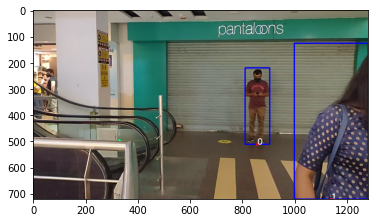

In [46]:
from tqdm import tqdm
thresh=200
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

In [63]:
image_folder='/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection/frames_update/'
fps=24

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('Social-Distancecctv.mp4')

t:   0%|          | 0/1500 [00:00<?, ?it/s, now=None]

Moviepy - Building video Social-Distancecctv.mp4.
Moviepy - Writing video Social-Distancecctv.mp4



Moviepy - Done !
Moviepy - video ready Social-Distancecctv.mp4


# Mask Detection

In [51]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [52]:
images = os.listdir('frames_update/')
images.sort(key=lambda f: int(re.sub('\D', '', f)))

In [53]:
image_folder='frames_update/'
image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))

In [54]:
image_files

['frames_update//0.png',
 'frames_update//1.png',
 'frames_update//2.png',
 'frames_update//3.png',
 'frames_update//4.png',
 'frames_update//5.png',
 'frames_update//6.png',
 'frames_update//7.png',
 'frames_update//8.png',
 'frames_update//9.png',
 'frames_update//10.png',
 'frames_update//11.png',
 'frames_update//12.png',
 'frames_update//13.png',
 'frames_update//14.png',
 'frames_update//15.png',
 'frames_update//16.png',
 'frames_update//17.png',
 'frames_update//18.png',
 'frames_update//19.png',
 'frames_update//20.png',
 'frames_update//21.png',
 'frames_update//22.png',
 'frames_update//23.png',
 'frames_update//24.png',
 'frames_update//25.png',
 'frames_update//26.png',
 'frames_update//27.png',
 'frames_update//28.png',
 'frames_update//29.png',
 'frames_update//30.png',
 'frames_update//31.png',
 'frames_update//32.png',
 'frames_update//33.png',
 'frames_update//34.png',
 'frames_update//35.png',
 'frames_update//36.png',
 'frames_update//37.png',
 'frames_update//38.pn

In [55]:
re.sub('\D', '', 'frames_update/\/0.png')

'0'

In [56]:
for image_path in image_files:
  #image = cv2.imread(image_path)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = Image.open(image_path)
  fn= re.sub('\D', '', image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)

  image_np1 = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) #testing
    
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np1, axis=0) 
  # Actual detection.
  boxes_m, scores_m, classes_m = detect_objects(image, detection_graph_mask, sess_mask)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.squeeze(boxes_m),
      np.squeeze(classes_m).astype(np.int32),
      np.squeeze(scores_m),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=3,
      min_score_thresh=0.85)
  
  cv2.imwrite('Mask_update/'+fn+'.png',cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
#   cv2.imwrite('Mask_update/'+fn+'.png',image_np)

  #plt.figure(figsize=IMAGE_SIZE)
#   plt.imshow(image_np)

# Video Creation

In [57]:
image_folder='/home/ubuntu/Desktop/Vivek/Social-Distancing&Mask-Detection/Mask_update/'
fps=24

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".png")]
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('Pantaloons- Social-Distance and Facemask detection.mp4')

t:   0%|          | 0/2001 [00:00<?, ?it/s, now=None]

Moviepy - Building video Pantaloons- Social-Distance and Facemask detection.mp4.
Moviepy - Writing video Pantaloons- Social-Distance and Facemask detection.mp4



Moviepy - Done !
Moviepy - video ready Pantaloons- Social-Distance and Facemask detection.mp4
